# import package

In [381]:
import os, time, io
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
import tensorflow as tf
import sklearn
from PIL import Image
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from cleverhans import utils_tf
from util import cvt2Image, sparse_tuple_from

# calamari predict

In [3]:
from calamari_ocr.ocr.backends.tensorflow_backend.tensorflow_model import TensorflowModel
from calamari_ocr.ocr import Predictor
checkpoint = '/home/chenlu/calamari/models/antiqua_modern/4.ckpt.json'
predictor = Predictor(checkpoint=checkpoint, batch_size=1, processes=10)

Checkpoint version 1 is up-to-date.
charset: ['', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}']
Using CUDNN LSTM backend on GPU
Successfully load the model's weights
INFO:tensorflow:Restoring parameters from /home/chenlu/calamari/models/antiqua_modern/4.ckpt


In [4]:
network = predictor.network
sess, graph = network.session, network.graph
codec = network.codec
charset = codec.charset
encode, decode = codec.encode, codec.decode
code2char, char2code = codec.code2char, codec.char2code

In [5]:
def invert(data): # 反色
    if data.max() < 1.5:
        return 1 - data
    else:
        return 255 - data

def transpose(data): # 旋转90度
    if len(data.shape) != 2:
        return np.swapaxes(data, 1, 2)
    else:
        return data.T

def cvt2raw(data):
    return transpose(invert(data))

def show(img):
    return cvt2Image(cvt2raw(img))

def top_k(lgt, k=2): # lgt: (n_sentence, n_char, n_classes)
    # return the top k probability characters' index(in charset)
    if k == 0:
        raise "k can't be 0."
    if k > 0:
        return np.argsort(lgt, axis=-1)[:, :, -k:][:, :, ::-1] # [0][:, 0] 第0句的所有位置最大概率的字母
    else: # k=-1
        return np.argsort(lgt, axis=-1)[:, :, :-k]
    
def preprocess(img_list):
    # preprocess the image before feeding it into the model
    images = [np.array(img_list[i].convert('L'), dtype='uint8') for i in range(len(img_list))]
    images, params = zip(*predictor.data_preproc.apply(images))
    images, len_x = network.zero_padding(images)  # padding images to same fixed-length images
    images = images / 255 # normalized images
    input_img = images.reshape(images.shape[:3])
    return input_img, len_x

# MIM attack graph

In [2405]:
# build graph
with graph.as_default():
    # _ 是data_iterator如果是dataset input的话
    inputs, input_seq_len, targets, dropout_rate, _, _ = network.create_placeholders()
    output_seq_len, time_major_logits, time_major_softmax, logits, softmax, decoded, sparse_decoded, scale_factor, log_prob = \
                        network.create_network(inputs, input_seq_len, dropout_rate, reuse_variables=tf.AUTO_REUSE)
    loss = tf.nn.ctc_loss(labels=targets,
                          inputs=time_major_logits,
                          sequence_length=output_seq_len,
                          time_major=True,
                          ctc_merge_repeated=True,
                          ignore_longer_outputs_than_inputs=True)
    loss = -tf.reduce_mean(loss, name='loss')
    grad, = tf.gradients(loss, inputs)

    # Normalize current gradient and add it to the accumulated gradient
    red_ind = list(range(1, len(grad.get_shape())))
    avoid_zero_div = tf.cast(1e-12, grad.dtype)
    divisor = tf.reduce_mean(tf.abs(grad), red_ind, keepdims=True)
    norm_grad = grad / tf.maximum(avoid_zero_div, divisor)

    m = tf.placeholder(tf.float32,
                       shape=inputs.get_shape().as_list(),
                       name="momentum")
    acc_m = m + norm_grad

    grad = acc_m
    # ord=np.inf
    optimal_perturbation = tf.sign(grad)
    optimal_perturbation = tf.stop_gradient(optimal_perturbation)
    scaled_perturbation_inf = utils_tf.mul(0.01, optimal_perturbation)
    # ord=2
    square = tf.maximum(1e-12, tf.reduce_sum(tf.square(grad), axis=red_ind, keepdims=True))
    optimal_perturbation = grad / tf.sqrt(square)
    scaled_perturbation_2 = utils_tf.mul(0.01, optimal_perturbation)

Using CUDNN LSTM backend on GPU


# word attack position

In [ ]:
with open('/home/chenlu/research/TextRecognitionDataGenerator/en_sim_dict.pkl', 'rb') as f:
    en_sim_dict = pickle.load(f)

with open('/home/chenlu/research/TextRecognitionDataGenerator/new_image_data/intersection_set.pkl', 'rb') as f:
    intersection = pickle.load(f)
sents = list(intersection)

import nltk
import nltk.data
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
words = []
for s in sents:
    words += nltk.word_tokenize(s)
    
from string import digits, ascii_letters
valid_char = digits+ascii_letters
invalid_char = []
for c in charset:
    if c not in valid_char:
        invalid_char.append(c)
invalid_char = set(invalid_char)

cand_words = []
for w in words:
    if len(set(w) & invalid_char) == 0:
        cand_words.append(w)
cand_words = list(set([w.lower() for w in list(set(cand_words))]))

from collections import defaultdict
attack_cands = defaultdict(list)
for w in cand_words:
    if len(en_sim_dict[w]) == 0:
        continue
    attack_cands[w] = en_sim_dict[w]
    
attack_pos = defaultdict() # {word1:{pos1:[c1, ...], pos2:...}, word2:...}
for w, attack_list in attack_cands.items():
    attack_w_dict = defaultdict(list)
    for attack_w in attack_list:
        w_array, attack_w_array = np.array(list(w)), np.array(list(attack_w))
        diff_index = w_array!=attack_w_array
        index = list(diff_index).index(True)
        diff_c = list(attack_w_array[diff_index])
        attack_w_dict[index] += diff_c
    attack_pos[w] = attack_w_dict
    
with open('/home/chenlu/research/TextRecognitionDataGenerator/intersect_image_data/attack_pos.pkl', 'wb') as f:
    pickle.dump(attack_pos, f)

# word level attack_pair
generate attack pairs which include **easy** pair, **random** pair and **hard** pair

In [ ]:
with open('/home/chenlu/research/TextRecognitionDataGenerator/intersect_image_data/attack_pos.pkl', 'rb') as f:
    attack_pos = pickle.load(f)

In [ ]:
for font in fonts:
    save_name = font.split('/')[-1][:-4]
    print(save_name)
    with open(
            f'/home/chenlu/research/TextRecognitionDataGenerator/word_image_data/{save_name}.pkl',
            'rb') as f:
        img_list, lbl_list = pickle.load(f)
    input_img, len_x = preprocess(img_list)
    # remove incorrect classification image
    with graph.as_default():
        decoded0 = sess.run(decoded,
                            feed_dict={
                                inputs: input_img,
                                input_seq_len: len_x,
                                dropout_rate: 0,
                            })
    pred_index = TensorflowModel._TensorflowModel__sparse_to_lists(decoded0)
    pred_label = [''.join(decode(index)) for index in pred_index]
    new_img_list, new_lbl_list, new_input_img, new_len_x = [], [], [], []
    bad_img_list, bad_lbl_list, bad_input_img, bad_len_x = [], [], [], []
    for i, (pred_txt, raw_txt) in enumerate(zip(pred_label, lbl_list)):
        if pred_txt == raw_txt:
            new_img_list.append(img_list[i])
            new_lbl_list.append(lbl_list[i])
            new_input_img.append(input_img[i])
            new_len_x.append(len_x[i])
        else:
            bad_img_list.append(img_list[i])
            bad_lbl_list.append(lbl_list[i])
            bad_input_img.append(input_img[i])
            bad_len_x.append(len_x[i])
    img_list, lbl_list, input_img, len_x = new_img_list, new_lbl_list, np.array(
        new_input_img), new_len_x

    # get the logits of the valid char to easy/random/hard case
    with graph.as_default():
        logits0 = sess.run(logits,
                           feed_dict={
                               inputs: input_img,
                               input_seq_len: len_x,
                               dropout_rate: 0,
                           })
    lgt = np.roll(logits0, shift=1, axis=2)  # 可以与charset的index对应上了
    labels = np.argmax(lgt, axis=-1)  # 概率最大的
    pred_res = []
    for i in range(lgt.shape[0]):
        text_index = decode(labels[i])
        sort_index = np.argsort(lgt[i], axis=-1)[:, ::-1]  # max probability in the front
        pred_res.append((text_index, sort_index))

    cands_index_list = []
    for k in range(len(pred_res)):
        text_index, sort_index = pred_res[k]
        gt_text = lbl_list[k]
        j = 0
        cands_index = []
        for i, c in enumerate(text_index):
            if c != '' and (
                (not (i > 0 and text_index[i] == text_index[i - 1])) or
                (i > 1 and text_index[i] == text_index[i - 2])):
                cands_index.append(sort_index[i])
                j += 1
        cands_index_list.append(np.asarray(cands_index))

    # best case: attack the second largest probability character
    # {word1:{pos1:[c1, ...], pos2:...}, word2:...}
    attack_pair = defaultdict()  # ordered attack_pos ordered by logits
    for i, w in enumerate(lbl_list):
        cands_index = cands_index_list[i]  # (len_w, n_classes)
        attack_c = attack_pos[w]  # {pos1:[c1, c2...], pos2:...}
        attack_pair_w = defaultdict(list)
        for j in range(len(w)):
            if attack_c[j] != []:
                # character index probability order in pos j
                index_order = cands_index[j]
                # candidate attack character index in pos j
                attack_index = encode(attack_c[j])
                attack_order_index = []  # 从前到后，概率从大到小
                for order in index_order:  # extract candidate attack character from the index order in order
                    if order in attack_index:
                        attack_order_index.append(order)
                attack_pair_w[j] = decode(attack_order_index)
        attack_pair[w] = attack_pair_w

    # 按照每个位置easy random hard 选取一个字母来attack
    from random import choice
    # {w1:{pos1:[w1_easy,w1_random,w1_hard], pos2:...}, word2:...}
    attack_candidates = defaultdict()
    for i, w in enumerate(lbl_list):
        attack_c = attack_pair[w]  # {pos1:[c1, c2...], pos2:...}
        attack_candidates_w = defaultdict(list)
        for j in range(len(w)):
            if attack_c[j] != []:
                ordered_c = attack_c[j]  # [c1, c2...]
                attack_candidates_w[j].append(w[:j] + ordered_c[0] + w[j + 1:])  # easy
                attack_candidates_w[j].append(w[:j] + choice(ordered_c) + w[j + 1:])  # random
                attack_candidates_w[j].append(w[:j] + ordered_c[-1] + w[j + 1:])  # hard
        attack_candidates[w] = attack_candidates_w

    easy_img_list, random_img_list, hard_img_list = [], [], []
    easy_input_img, random_input_img, hard_input_img = [], [], []
    easy_len_x, random_len_x, hard_len_x = [], [], []
    easy_gt_txt, random_gt_txt, hard_gt_txt = [], [], []
    easy_target_txt, random_target_txt, hard_target_txt = [], [], []

    for i, w in enumerate(lbl_list):
        # {pos1:[w1_easy,w1_random,w1_hard], pos2:...}
        attack_c = attack_candidates[w]
        for j in range(len(w)):
            if attack_c[j] != []:
                # easy
                easy_img_list.append(img_list[i])
                easy_input_img.append(input_img[i])
                easy_len_x.append(len_x[i])
                easy_gt_txt.append(lbl_list[i])
                easy_target_txt.append(attack_c[j][0])

                # random
                random_img_list.append(img_list[i])
                random_input_img.append(input_img[i])
                random_len_x.append(len_x[i])
                random_gt_txt.append(lbl_list[i])
                random_target_txt.append(attack_c[j][1])

                # hard
                hard_img_list.append(img_list[i])
                hard_input_img.append(input_img[i])
                hard_len_x.append(len_x[i])
                hard_gt_txt.append(lbl_list[i])
                hard_target_txt.append(attack_c[j][2])

    with open(
            f'/home/chenlu/research/TextRecognitionDataGenerator/word_image_data/{save_name}-easy.pkl',
            'wb') as f:
        pickle.dump((easy_img_list, np.asarray(easy_input_img), easy_len_x, easy_gt_txt, easy_target_txt),
                    f)
    with open(
            f'/home/chenlu/research/TextRecognitionDataGenerator/word_image_data/{save_name}-random.pkl',
            'wb') as f:
        pickle.dump(
            (random_img_list, np.asarray(random_input_img), random_len_x, random_gt_txt, random_target_txt),
            f)
    with open(
            f'/home/chenlu/research/TextRecognitionDataGenerator/word_image_data/{save_name}-hard.pkl',
            'wb') as f:
        pickle.dump((hard_img_list, np.asarray(hard_input_img), hard_len_x, hard_gt_txt, hard_target_txt),
                    f)

# word attack pair

In [477]:
# load English dictionary en_list
from trdg.utils import load_dict
en_list = load_dict('en_alpha') # 只包括字母的单词

# 将English dictionary中的word按照长度分类 en_dict
from collections import defaultdict
en_dict = defaultdict(list)
for w in en_list:
    en_dict[len(w)].append(w.lower())

In [502]:
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'
fonts = ['Courierbd','Georgiabd','Helveticabd','timesbd','Arialbd','Courier','Georgia','Helvetica','times','Arial']
case = 'easy'
import random as rnd
import Levenshtein
for font_name in fonts[1:]:
    print(font_name)
    with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
        img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)
    input_img = np.asarray(input_img)
    raw_set = set()
    raw_img_list, raw_input_img, raw_len_x, raw_gt_txt = [], [], [], []
    for i, w in enumerate(gt_txt):
        if w not in raw_set:
            raw_set.add(w)
            raw_img_list.append(img_list[i])
            raw_input_img.append(input_img[i])
            raw_len_x.append(len_x[i])
            raw_gt_txt.append(gt_txt[i])
    img_list, input_img, len_x, gt_txt = raw_img_list, np.asarray(raw_input_img), raw_len_x, raw_gt_txt
    
    # replace the whole word randomly which choose from en_dict (same length)
    target_txt = [rnd.choice(en_dict[len(w)]) for w in gt_txt]
    with open(f'{img_data_path}/{font_name}-replace-full-word.pkl', 'wb') as f:
        pickle.dump((img_list, input_img, len_x, gt_txt, target_txt), f)
    
    # replace one character
    replace_dict = defaultdict(list)
    for w1 in gt_txt:
        for w2 in en_dict[len(w1)]:
            if Levenshtein.distance(w1, w2) == 1:
                replace_dict[w1].append(w2)
    target_txt = [rnd.choice(replace_dict[w]) for w in gt_txt]
    with open(f'{img_data_path}/{font_name}-replace.pkl', 'wb') as f:
        pickle.dump((img_list, input_img, len_x, gt_txt, target_txt), f)
    
    # delete one character
    delete_dict = defaultdict(list)
    for w1 in gt_txt:
        for w2 in en_dict[len(w1)-1]:
            if Levenshtein.distance(w1, w2) == 1:
                delete_dict[w1].append(w2)
    target_txt = []
    for w in gt_txt:
        if len(delete_dict[w]) > 0:
            target_txt.append(rnd.choice(delete_dict[w]))
        else:
            target_txt.append(w[:-1])
    with open(f'{img_data_path}/{font_name}-delete.pkl', 'wb') as f:
        pickle.dump((img_list, input_img, len_x, gt_txt, target_txt), f)
    
     # insert one character
    insert_dict = defaultdict(list)
    for w1 in gt_txt:
        for w2 in en_dict[len(w1)+1]:
            if Levenshtein.distance(w1, w2) == 1:
                insert_dict[w1].append(w2)
    target_txt = []
    for w in gt_txt:
        if len(insert_dict[w]) > 0:
            target_txt.append(rnd.choice(insert_dict[w]))
        else:
            target_txt.append(w+'a')            
    with open(f'{img_data_path}/{font_name}-insert.pkl', 'wb') as f:
        pickle.dump((img_list, input_img, len_x, gt_txt, target_txt), f)

Georgiabd
Helveticabd
timesbd
Arialbd
Courier
Georgia
Helvetica
times
Arial


In [1826]:
def attack(input_img, len_x, target_txt, pert_type='2'):
    target_index_list = [np.asarray([c for c in encode(t)]) for t in target_txt]
    with graph.as_default():
        adv_img = input_img.copy()
        m0 = np.zeros(input_img.shape)
        record_iter = np.zeros(input_img.shape[0])  # 0代表没成功

        start = time.time()
        for i in tqdm(range(nb_iter)):
            # perform attack
            batch_iter = len(input_img) // batch_size
            batch_iter = batch_iter if len(input_img) % batch_size == 0 else batch_iter + 1
            for batch_i in range(batch_iter):
                batch_input_img = input_img[batch_size * batch_i:batch_size * (batch_i + 1)]
                batch_adv_img = adv_img[batch_size * batch_i:batch_size * (batch_i + 1)]
                batch_len_x = len_x[batch_size * batch_i:batch_size * (batch_i + 1)]
                batch_m0 = m0[batch_size * batch_i:batch_size * (batch_i + 1)]
                batch_target_txt = target_txt[batch_size * batch_i:batch_size * (batch_i + 1)]
                batch_tmp_y = [np.asarray([c - 1 for c in encode(t)]) for t in batch_target_txt]
                batch_y = sparse_tuple_from(batch_tmp_y)
                batch_record_iter = record_iter[batch_size * batch_i:batch_size * (batch_i + 1)]

                scaled_perturbation = scaled_perturbation_2 if pert_type == '2' else scaled_perturbation_inf
                batch_pert = sess.run(scaled_perturbation, # pert type
                                      feed_dict={
                                          inputs: batch_adv_img,
                                          input_seq_len: batch_len_x,
                                          m: batch_m0,
                                          targets: batch_y,
                                          dropout_rate: 0,
                                      })
                batch_pert[batch_pert > 0] = 0 ###########################3
                batch_pert[batch_record_iter != 0] = 0
                batch_adv_img = batch_adv_img + eps_iter * batch_pert
                batch_adv_img = batch_input_img + np.clip(batch_adv_img - batch_input_img, -eps, eps)
                batch_adv_img = np.clip(batch_adv_img, clip_min, clip_max)
                adv_img[batch_size * batch_i:batch_size * (batch_i + 1)] = batch_adv_img

            record_adv_text = []
            # check whether attack success
            for batch_i in range(batch_iter):
                batch_adv_img = adv_img[batch_size * batch_i:batch_size * (batch_i + 1)]
                batch_len_x = len_x[batch_size * batch_i:batch_size * (batch_i + 1)]
                batch_target_index = target_index_list[batch_size * batch_i:batch_size * (batch_i + 1)]
                batch_adv_text = sess.run(decoded,
                                          feed_dict={
                                              inputs: batch_adv_img,
                                              input_seq_len: batch_len_x,
                                              dropout_rate: 0,
                                          })
                batch_adv_index = TensorflowModel._TensorflowModel__sparse_to_lists(batch_adv_text)
                record_adv_text += [''.join(decode(index)) for index in batch_adv_index]
                for j in range(len(batch_target_index)):
                    # attack img idx_j successfully at iter i
                    idx_j = batch_size * batch_i + j
                    adv_index, target_index = batch_adv_index[j], batch_target_index[j]
                    if np.sum(adv_index != target_index) == 0 and record_iter[idx_j] == 0:
                        record_iter[idx_j] = i
            # check whether all examples are successful
            if np.sum(record_iter == 0) == 0:
                break

        duration = time.time() - start
        print(f"{i} break. Time cost {duration:.4f} s")
    return adv_img, record_adv_text, record_iter, (duration, i)

In [ ]:
adv_img, record_adv_text, record_iter, (duration, i) = attack(input_img, len_x, target_txt)
with open(f'attack_result/{title}-replace-full-word.pkl', 'wb') as f:
    pickle.dump((adv_img, record_adv_text, record_iter, (duration, i)), f)

# word attack pair--protect

In [629]:
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'
fonts = ['Courier','Georgia','Helvetica','times','Arial', 'Courierbd','Georgiabd','Helveticabd','timesbd','Arialbd']
case = 'easy'
import random as rnd
import Levenshtein
for font_name in tqdm(fonts[:5]):
    with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
        img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)
    input_img = np.asarray(input_img)
    raw_set = set()
    raw_img_list, raw_input_img, raw_len_x, raw_gt_txt = [], [], [], []
    for i, w in enumerate(gt_txt):
        if w not in raw_set:
            raw_set.add(w)
            raw_img_list.append(img_list[i])
            raw_input_img.append(input_img[i])
            raw_len_x.append(len_x[i])
            raw_gt_txt.append(gt_txt[i])
    img_list, input_img, len_x, gt_txt = raw_img_list, np.asarray(raw_input_img), raw_len_x, raw_gt_txt
    
    with open(f'{img_data_path}/{font_name}-protect.pkl', 'wb') as f:
        pickle.dump((img_list, input_img, len_x, gt_txt, gt_txt), f)

Courier
Georgia
Helvetica
times
Arial


# run word attack procedure

In [373]:
clip_min, clip_max = 0.0, 1.0
eps = 0.2
nb_iter = 1000
batch_size = 100
pert_type = '2'
eps_iter = 5.0
case = 'easy'
font_name = 'Arial'

In [378]:
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'
with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
    img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)
input_img = np.asarray(input_img)
input_img, len_x, target_txt = input_img[:1], len_x[:1], target_txt[:1]

In [390]:
target_index_list = [np.asarray([c for c in encode(t)]) for t in target_txt]
with graph.as_default():
    adv_img = input_img.copy()
    m0 = np.zeros(input_img.shape)
    record_iter = np.zeros(input_img.shape[0])  # 0代表没成功

    start = time.time()
    for i in tqdm(range(nb_iter)):
        batch_iter = len(input_img) // batch_size
        batch_iter = batch_iter if len(input_img) % batch_size == 0 else batch_iter + 1
        for batch_i in range(batch_iter):
            batch_input_img = input_img[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_adv_img = adv_img[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_len_x = len_x[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_m0 = m0[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_target_txt = target_txt[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_tmp_y = [np.asarray([c - 1 for c in encode(t)])for t in batch_target_txt]
            batch_y = sparse_tuple_from(batch_tmp_y)
            batch_record_iter = record_iter[batch_size * batch_i:batch_size * (batch_i + 1)]
            
            scaled_perturbation = scaled_perturbation_2 if pert_type == '2' else scaled_perturbation_inf
            batch_pert = sess.run(scaled_perturbation,
                                  feed_dict={
                                      inputs: batch_adv_img,
                                      input_seq_len: batch_len_x,
                                      m: batch_m0,
                                      targets: batch_y,
                                      dropout_rate: 0,
                                  })
            batch_pert[batch_record_iter != 0] = 0
            batch_adv_img = batch_adv_img + eps_iter * batch_pert
            batch_adv_img = batch_input_img + np.clip(batch_adv_img - batch_input_img, -eps, eps)
            batch_adv_img = np.clip(batch_adv_img, clip_min, clip_max)
            adv_img[batch_size * batch_i:batch_size * (batch_i + 1)] = batch_adv_img
        
        record_adv_text = []
        for batch_i in range(batch_iter):
            batch_adv_img = adv_img[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_len_x = len_x[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_target_index = target_index_list[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_adv_text = sess.run(decoded,
                                      feed_dict={
                                          inputs: batch_adv_img,
                                          input_seq_len: batch_len_x,
                                          dropout_rate: 0,
                                      })
            batch_adv_index = TensorflowModel._TensorflowModel__sparse_to_lists(batch_adv_text)
            record_adv_text += [''.join(decode(index)) for index in batch_adv_index]
            for j in (range(len(batch_target_index))):
                # attack img j successfully at iter i
                adv_index, target_index = batch_adv_index[j], batch_target_index[j]
                idx_j = batch_size * batch_i + j
                if np.sum(adv_index != target_index) == 0 and record_iter[idx_j] == 0:
                    record_iter[idx_j] = i
        if np.sum(record_iter == 0) == 0:  # all examples are successful
            print(i, 'break')
            break
    duration = time.time() - start
    print(f"Time cost {duration} s")

  7%|▋         | 68/1000 [00:01<00:15, 61.35it/s]

68 break
Time cost 1.1245481967926025 s


# check decoded

In [2959]:
with graph.as_default():
    adv_text = sess.run(decoded,
                        feed_dict={
                            inputs:  adv_img,
                            input_seq_len: len_x,
                            dropout_rate: 0,
                        })
    adv_index = TensorflowModel._TensorflowModel__sparse_to_lists(adv_text)
    adv_text = [''.join(decode(index)) for index in adv_index]

In [2960]:
adv_text

['Ts s one of the funniest movies  have overseen',
 ' This, im my opinion, is Rob Lowe at his best, 1m not',
 'quite sure, uhy this fim has gotten such a low rating']

# check gradient

In [639]:
with graph.as_default():
    tmp_y = [np.asarray([c - 1 for c in encode(t)])for t in target_txt[:10]]
    y = sparse_tuple_from(tmp_y)
    grad0 = sess.run(grad,
                        feed_dict={
                            inputs: input_img[:10],
                            input_seq_len: len_x[:10],
                            targets: y,
                            m:np.zeros(input_img.shape)[:10],
                            dropout_rate: 0,
                        })

In [650]:
a = np.argsort(grad0[0].reshape(-1)).reshape((193, 48))

In [669]:
kernel = np.ones((5, 5), np.uint8)
grad_erode = cv2.erode(transpose(grad0[1]), kernel, iterations=2)
# plt.imshow(cv2.erode(transpose(grad0[0]), kernel, iterations=2))

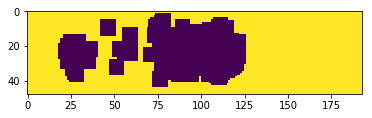

In [672]:
plt.imshow(cv2.threshold(grad_erode, np.mean(grad_erode), 1, 0)[1])

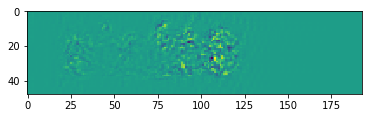

In [673]:
plt.imshow(transpose(grad0[1]))

# measure

In [12]:
clip_min, clip_max = 0.0, 1.0
eps = 0.2
nb_iter = 1000
batch_size = 100
pert_type = '2'
eps_iter = 5.0
case = 'easy'
font_name = 'Arial'

In [13]:
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'
with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
    img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)
input_img = np.asarray(input_img)
input_img, len_x, target_txt = input_img[:100], len_x[:100], target_txt[:100]

In [14]:
title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
with open(f'attack_result/{title}.pkl', 'rb') as f:
    adv_img, record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)
adv_img, record_adv_text, record_iter = adv_img[:100], record_adv_text[:100], record_iter[:100]

In [15]:
from skimage.measure import compare_ssim, compare_mse, compare_psnr
def pert_eval(image0, image1):
    image0 = (255 * cvt2raw(image0)).astype('uint8')
    image1 = (255 * cvt2raw(image1)).astype('uint8')
    return compare_mse(image0, image1), compare_psnr(image0, image1), compare_ssim(image0, image1)

In [17]:
pert_eval(adv_img, input_img)

(31.02243847150259, 33.21404428992657, 0.9708506367147172)

In [18]:
asr_t = np.sum(record_iter != 0) / len(record_iter)  # targeted asr
avg_attack_iter = np.mean(record_iter[record_iter != 0])
avg_iter_time = duration / total_iter

# find wm position

In [175]:
from skimage import morphology
import cv2
def find_wm_pos(adv_img, input_img, ret_frame_img=False):
    pert = np.abs(cvt2raw(adv_img) - cvt2raw(input_img))
    pert = (pert > 3 * 1e-2) * 255.0
    remove_list = []
    wm_pos_list = []
    frame_img_list = []
    for src in pert:
        kernel = np.ones((3, 3), np.uint8)  # 设置卷积核3*3
        dilate = cv2.dilate(src, kernel, iterations=2)  # 图像的膨胀
        erode = cv2.erode(dilate, kernel, iterations=2)  # 图像的腐蚀
        remove = morphology.remove_small_objects(erode.astype('bool'), min_size=150)
        remove_list.append(remove)
        contours, _ = cv2.findContours((remove * 255).astype('uint8'),
                                       cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        wm_pos, frame_img = [], []
        for cont in contours:
            left_point = cont.min(axis=1).min(axis=0)
            right_point = cont.max(axis=1).max(axis=0)
            wm_pos.append(np.hstack((left_point, right_point)))
            if ret_frame_img:
                img = cv2.rectangle(
                    (remove * 255).astype('uint8'), (left_point[0], left_point[1]),
                    (right_point[0], right_point[1]), (255, 255, 255), 2)
                frame_img.append(img)
        wm_pos_list.append(wm_pos)
        frame_img_list.append(frame_img)
    
    if ret_frame_img:
        return (wm_pos_list, frame_img_list)
    else:
        return wm_pos_list

In [20]:
pos, frames = find_wm_pos(adv_img, input_img, True)

In [21]:
# 按面积大小把pos从大到小排个序
new_pos = []
for _pos in pos:
    if len(_pos) > 1:
        new_pos.append(sorted(_pos, key=lambda x: (x[3]-x[1])*(x[2]-x[0]), reverse=True))
    else:
        new_pos.append(_pos)
pos = new_pos

In [23]:
max_area = [(x[0][3]-x[0][1])*(x[0][2]-x[0][0]) for x in pos]

# wm generation

In [3003]:
from trdg.generators import GeneratorFromStrings

def gen_wm(RGB):
    generator = GeneratorFromStrings(
        strings=['ecml'],
        count=1,  # 五种字体
        fonts=['Impact.ttf'],  # default: []
        language='en',
        size=200,  # 32
        skewing_angle=10,
        random_skew=False,
        blur=0,
        random_blur=False,
        # gaussian noise (0), plain white (1), quasicrystal (2) or picture (3)
        background_type=1,
        distorsion_type=0,  # None(0), Sine wave(1),Cosine wave(2),Random(3)
        distorsion_orientation=0,
        is_handwritten=False,
        width=-1,
        alignment=1,
        text_color=RGB2Hex(RGB),
        orientation=0,
        space_width=1.0,
        character_spacing=0,
        margins=(0, 0, 0, 0),
        fit=True,
    )
    img_list = [img for img, _ in generator]
    return img_list[0]

In [366]:
# RGB格式颜色转换为16进制颜色格式
def RGB2Hex(RGB): # RGB is a 3-tuple
    color = '#'
    for num in RGB:
        color += str(hex(num))[-2:].replace('x', '0').upper()
    return color

In [367]:
wm_img = gen_wm((0, 0, 0))
wm_arr = np.array(wm_img.convert('L'))
kernel = np.ones((5, 5), np.uint8)
wm_arr = cv2.dilate(wm_arr, kernel, 2)
wm_arr = cv2.erode(wm_arr, kernel, 2)
bg_mask = ~(wm_arr != 255)
wm_img = np.array(Image.new(mode="RGB", size=wm_img.size, color=(255, 255, 0)))
wm_img[bg_mask] = 255
wm_img = Image.fromarray(wm_img)

# attach wm in pert_pos

In [321]:
def get_text_mask(img: np.array):
    if img.max() <= 1:
        return img < 1 / 1.25
    else:
        return img < 255 / 1.25

In [320]:
text_img = show(input_img[3])
pert_pos = pos[3][0]

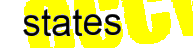

In [344]:
# height = max(wm_img.size[1], text_img.size[1])
# width = max(wm_img.size[0], text_img.size[0])
rgb_img = Image.new(mode="RGB", size=text_img.size, color=(255, 255, 255))
p = -int(wm_img.size[0] * np.tan(10 * np.pi / 180))
rgb_img.paste(wm_img, box=(pert_pos[0], p))
text_mask = get_text_mask(np.array(text_img))
rgb_img.paste(text_img, mask=cvt2Image(text_mask))
rgb_img

In [3034]:
wm_mask.shape, text_mask.shape

((587, 3196), (587, 3196))

# convert gray wm to rgb

In [342]:
def cvt2rgb(gray_img: np.array, text_mask: np.array) -> np.array:
    op_mask = (~(gray_img == 255)) & (~text_mask) # not_bg & not_text
    rgb_img = np.array(Image.fromarray(gray_img).convert('RGB'))
    rgb_img[op_mask, 0] = 255
    rgb_img[op_mask, 1] = np.clip(((1000 * gray_img[op_mask] - 255 * 299) / 587).astype('uint8'), 0, 255)
    rgb_img[op_mask, 2] = 0
    return rgb_img

In [345]:
gray_img = np.array(rgb_img.convert('L'))
rgb_img = cvt2rgb(gray_img, text_mask)

draft、sample、watermark、eccv、confidential、logo、certificate

# wm measure

In [ ]:
def get_text_mask(img: np.array):
    if img.max() <= 1:
        return img < 1 / 1.25
    else:
        return img < 255 / 1.25

In [ ]:
bg_mask = 1 - get_text_mask(cvt2raw(input_img))

In [ ]:
def watermark_measure(raw_img, adv_img):
    text_mask = get_text_mask(raw_img)
    bg_mask = 1 - text_mask
    mse_text = compare_mse(raw_img * text_mask, adv_img * text_mask)
    mse_bg = compare_mse(raw_img * bg_mask, adv_img * bg_mask)
    pixel_text = np.sum(text_mask)
    pixel_bg = np.sum(bg_mask)
    pixel_total = pixel_text + pixel_bg
    return pixel_text / pixel_total * mse_text + pixel_bg / pixel_total * mse_bg

In [ ]:
def text_measure(raw_img, adv_img):
    text_mask = get_text_mask(raw_img)
    return compare_mse(raw_img * text_mask, adv_img * text_mask)

def bg_measure(raw_img, adv_img):
    bg_mask = 1- get_text_mask(raw_img)
    return compare_mse(raw_img * bg_mask, adv_img * bg_mask)

In [ ]:
def paste_watermark(text_img: Image.Image, wm_img: Image.Image, pos):
    text_arr = np.array(text_img)
    text_mask = get_text_mask(np.array(text_img.convert('L')))
    text_mask = cvt2Image(text_mask)
    height = max(wm_img.size[1], text_img.size[1])
    width = max(wm_img.size[0], text_img.size[0])
    new_img = cvt2Image(np.ones((height, width)) * 255).convert('RGB')
    new_img.paste(wm_img, box=(int(pos * new_img.size[0]), 0))
    new_img.paste(text_img, mask=text_mask)
    return new_img

In [ ]:
text_mask = get_text_mask(cvt2raw(input_img))

In [ ]:
new_shape = (max(wm_img.size[1], text_img.size[1]), max(wm_img.size[0], text_img.size[0]))
new_img = np.ones(text_mask.shape) * 255

In [ ]:
text_mask = cvt2Image(text_mask)
new_img = cvt2Image(np.ones((max(wm_img.size[1], text_img.size[1]), max(wm_img.size[0], text_img.size[0]))) * 255).convert('RGB')
new_img.paste(wm_img, box=(int(pos * new_img.size[0]), 0))
new_img.paste(text_img, mask=text_mask)

# Transferability

## baidu OCR

In [ ]:
import io
from aip import AipOcr
""" 你的 APPID AK SK """
APP_ID = '15932731'
API_KEY = '67gWka2xTeiIMq19T0WGkATt'
SECRET_KEY = 'MQVPtAVGSVaTzlhRqgpOvjSTgqCQD3Rz'
client = AipOcr(APP_ID, API_KEY, SECRET_KEY)
access_token = "24.04492c6323a2107717fd9467ae2513b7.2592000.1556894551.282335-15932731"

options = {
    "language_type": "CHN_ENG",
    "detect_direction": "true",
    "detect_language": "true",
    "probability": "true"
}

def baiduOCR(img):  # PIL.Image
    output = io.BytesIO()
    img.save(output, format='PNG')
    hex_data = output.getvalue()
    return client.basicGeneral(hex_data, options)


def baiduOCR2(img_path):
    with open(img_path, 'rb') as fp:
        image = fp.read()
    return client.basicGeneral(image, options)  # 带参数调用通用文字识别, 图片参数为本地图片

In [ ]:
baiduOCR(show(adv_img[0]))

## tesseract OCR

In [740]:
import pytesseract

In [ ]:
tesseract_img = show(adv_img[0])
print(pytesseract.image_to_string(tesseract_img, lang='eng'))

# 图像降噪

In [ ]:
# -*- coding: utf-8 -*-
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
img=cv2.imread('tmp_img.jpg', 0) #原图为彩色图，可将第二个参数变为0，为灰度图

In [ ]:
img = np.array(img_list[0].convert('L'), dtype='uint8')

In [ ]:
laplacian=cv2.Laplacian(img,cv2.CV_64F)#cv2.CV_64F输出图像的数据类型，可以使用-1，与原图像保持一致
sobelx=cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)# 参数 1,0 ，其中1是只在 x 方向求一阶导数，0是y方向不求导数，其最大可以求2阶导数。
sobely=cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)  # 参数 1,0 ，其中1是只在 y 方向求一阶导数，0是x方向不求导数，其最大可以求2阶导数。

In [ ]:
from keras.utils import to_categorical
def encode(text):
    return to_categorical(predictor.codec.encode(text), num_classes=len(predictor.codec.charset))
def decode(pred: np.array):
    # pred.shape: (n_text, nb_classes)
    pred_idx = pred.argmax(axis=-1)
    return ''.join(predictor.codec.decode(pred_idx))

In [ ]:
cnt = 0
for tensor_name in tf.contrib.graph_editor.get_tensors(graph):
    cnt += 1
cnt

# sentence attack

In [547]:
import random
def find_new_word(w):
    new_w = random.choice(en_dict[len(w)])
    if w.istitle():
        new_w = new_w[0].upper() + new_w[1:]
    return new_w

In [506]:
# load English dictionary en_list
from trdg.utils import load_dict
en_list = load_dict('en_alpha') # 只包括字母的单词

# 将English dictionary中的word按照长度分类 en_dict
from collections import defaultdict
en_dict = defaultdict(list)
for w in en_list:
    en_dict[len(w)].append(w.lower())

In [600]:
import re
import nltk
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/intersect_image_data'
fonts = ['Courierbd','Georgiabd','Helveticabd','timesbd','Arialbd',
         'Courier','Georgia','Helvetica','times','Arial']
for font_name in fonts:
    print(font_name)
    # load sentence image data
    with open(f'{img_data_path}/{font_name}-input.pkl', 'rb') as f:
        input_img, gt_txt, len_x = pickle.load(f)
    with open(f'{img_data_path}/{font_name}.pkl', 'rb') as f:
        img_list, _ = pickle.load(f)
    
    # replace a random word in a sentence
    sent_split = [s.split(' ') for s in gt_txt]
    new_target_txt = []
    for j, sent in enumerate(sent_split):
        for i, w in enumerate(sent):
            if 3 <= len(w) <= 6 and re.match(r'^[a-z]*$', w.lower()):
                new_target_txt.append(' '.join(sent[:i] + [find_new_word(w)] + sent[i + 1:]))
                break
        if i == len(sent) - 1 and not (3 <= len(w) <= 6 and re.match(r'^[a-z]*$', w.lower())):
            new_target_txt.append(' '.join(sent))
    with open(f'{img_data_path}/{font_name}-word.pkl', 'wb') as f:
        pickle.dump((img_list, input_img, len_x, gt_txt, new_target_txt), f)
        
    # replace the whole sentence
    new_target_txt = []
    for sent in sent_split:
        target_txt_i = []
        for w in sent:
            if 3 <= len(w) <= 14 and re.match(r'^[a-z]*$', w.lower()):
                target_txt_i.append(find_new_word(w))
            else:
                target_txt_i.append(w)
        new_target_txt.append(' '.join(target_txt_i))
    with open(f'{img_data_path}/{font_name}-sentence.pkl', 'wb') as f:
        pickle.dump((img_list, input_img, len_x, gt_txt, new_target_txt), f)

Courierbd
1479
1479
Georgiabd
1479
1479
Helveticabd
1479
1479
timesbd
1479
1479
Arialbd
1479
1479
Courier
1479
1479
Georgia
1479
1479
Helvetica
1479
1479
times
1479
1479
Arial
1479
1479


In [576]:
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/intersect_image_data'
font_name = 'times'
with open(f'{img_data_path}/{font_name}-word.pkl', 'rb') as f:
    img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)
input_img = np.asarray(input_img)

In [ ]:
adv_img, record_adv_text, record_iter, (duration, i) = attack(input_img[300:400], len_x[300:400], target_txt[300:400])

# find intersect word image

In [601]:
img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'
fonts = ['Courierbd','Georgiabd','Helveticabd','timesbd','Arialbd','Courier','Georgia','Helvetica','times','Arial']
case = 'easy'
with open(f'{img_data_path}/{fonts[0]}-{case}.pkl', 'rb') as f:
    _, _, _, gt_txt, _ = pickle.load(f)
intersect_word = set(gt_txt)
for font_name in fonts[1:]:
    print(font_name)
    with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
        _, _, _, gt_txt, _ = pickle.load(f)
    intersect_word = intersect_word.intersection(set(gt_txt))

Georgiabd
Helveticabd
timesbd
Arialbd
Courier
Georgia
Helvetica
times
Arial


In [605]:
with open(f'{img_data_path}/intersect_word.pkl', 'wb') as f: 
    pickle.dump(list(intersect_word), f)

# paragraph

In [2195]:
# # paragraph
# sentence_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/paragraph_image_data/'
# with open(f'{sentence_data_path}/Arial-new.pkl', 'wb') as f:
#     pickle.dump((cand_img_list, cand_input_img, cand_len_x, cand_gt_txt), f)

In [3038]:
# # paragraph
# sentence_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/paragraph_image_data'
# with open(f'{sentence_data_path}/Arial-paragraph.pkl', 'rb') as f:
#     _, input_img, len_x, gt_txt, target_txt = pickle.load(f)

In [3113]:
# paragraph
sentence_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/paragraph_image_data/'
with open(f'{sentence_data_path}/{fonts[4]}-sin.pkl', 'rb') as f:
    img_list, line_img_list, gt_txt = pickle.load(f)

In [2548]:
target_txt = [
    'This is one of the scariest movies I have ever seen. This,',
    "in my opinion, is Rob Lowe at his worst. I'm not quite sure",
    'why this film has gotten such a high rating. I guess you',
    'either love it or hate it, but if nothing else, it is not',
    'definitely worth a rental.'
]
# ['This is one of the funniest movies I have ever seen. This,',
#  "in my opinion, is Rob Lowe at his best. I'm not quite sure",
#  'why this film has gotten such a low rating. I guess you',
#  'either love it or hate it, but if nothing else, it is',
#  'definitely worth a rental.']

SyntaxError: invalid syntax (<ipython-input-2548-1ac5aaa2ff90>, line 6)

In [3114]:
line_img = []
for line_list in line_img_list:
    line_img += line_list

line_text = []
for g_txt in gt_txt:
    line_text += g_txt
    
len_x = [img.size[0] for img in line_img]
nb_line = len(line_img)
input_img = (np.ones((len(line_img), 48, max(len_x))) * 255).astype('uint8')
for row, ih in enumerate(range(nb_line)):
    input_img[row, :, :line_img[row].size[0]] = np.array(line_img[row])
input_img = np.swapaxes(1 - (input_img / 255), 1, 2)

In [3115]:
input_img, len_x = preprocess(line_img)
_, width, height = input_img.shape
# backup_img = input_img.copy()
# backup_len_x = len_x.copy()

In [3116]:
idx_para = 1
s, e = record[idx_para], record[idx_para+1]
img = show(input_img[s:e].swapaxes(1, 2).reshape(((e-s)*48, width)).T)

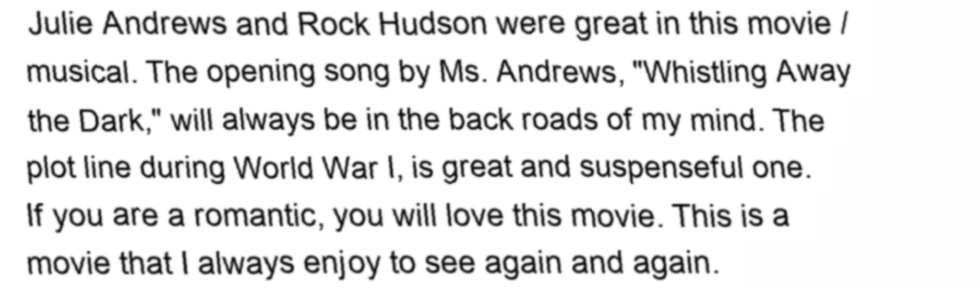

In [3117]:
img

In [3118]:
cand_input_img = []
cand_len_x = []
cand_gt_txt = []
# for i in range(len(line_img_num)):
for i in [1]:
    print(i)
    s, e = record[i], record[i+1]
    adv_img, record_adv_text, record_iter, (duration, i) = attack(input_img[s:e], len_x[s:e], line_text[s:e])
    if np.sum(record_iter == 0) == 0:
        cand_input_img.append(adv_img)
        cand_len_x.append(len_x[s:e])
        cand_gt_txt.append(line_text[s:e])
cand_input_img = np.asarray(cand_input_img)



































































  0%|          | 0/1000 [00:00<?, ?it/s]/home/chenlu/anaconda2/envs/ocr1/lib/python3.6/site-packages/ipykernel/__main__.py:57: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


































































  0%|          | 1/1000 [00:00<02:17,  7.25it/s]

1




































































  0%|          | 3/1000 [00:00<01:59,  8.32it/s]

































































  0%|          | 5/1000 [00:00<01:47,  9.28it/s]

































































  1%|          | 7/1000 [00:00<01:38, 10.06it/s]

































































  1%|          | 9/1000 [00:00<01:32, 10.68it/s]

































































  1%|          | 11/1000 [00:00<01:27, 11.26it/s]

































































  1%|▏         | 13/1000 [00:01<01:22, 11.97it/s]

































































  2%|▏         | 15/1000 [00:01<01:18, 12.52it/s]

16 break. Time cost 1.3710 s


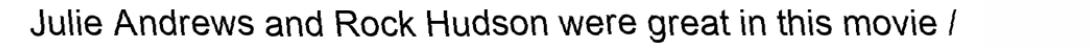

In [3112]:
show(cand_input_img[0][0])

In [2118]:
# input_img = backup_img.copy()
# len_x = backup_len_x.copy()

In [3078]:
line_img_num = [len(line) for line in gt_txt]
record = [0]
for nb in line_img_num:
    record.append(record[-1] + nb)

In [3079]:
input_img = np.swapaxes(input_img, 1, 2)

In [3080]:
img_list = [] 
split_input_img = []
split_len_x = []
for i in range(len(line_img_num)):
    imgi = input_img[record[i]:record[i + 1]]
    nbi = line_img_num[i]
    tmp_img = cvt2Image(1 - imgi.reshape((48 * nbi, width)))
    img_list.append(tmp_img)
    tmp_input_img = np.swapaxes(imgi, 1, 2)
    split_input_img.append(tmp_input_img)
    split_len_x.append(len_x[record[i]:record[i + 1]])

In [3081]:
input_img = np.swapaxes(input_img, 1, 2)

In [3082]:
def predict(img, len_x):
    with graph.as_default():
        pred_text = sess.run(decoded,
                            feed_dict={
                                inputs: img,
                                input_seq_len: len_x,
                                dropout_rate: 0,
                            })
        pred_index = TensorflowModel._TensorflowModel__sparse_to_lists(pred_text)
        return [''.join(decode(index)) for index in pred_index]

In [3119]:
pred_text = predict(cand_input_img[0], cand_len_x[0])

In [3120]:
pred_text

['Julie Andrews and Rock Hudson were great in this movie /',
 'musical. The opening song by Ms. Andrews, "Whistling Away',
 'the Dark," will always be in the back roads of my mind. The',
 'plot line during World War I, is great and suspenseful one.',
 'If you are a romantic, you will love this movie. This is a',
 'movie that I always enjoy to see again and again.']

In [3121]:
pred_text = predict(input_img[s:e], cand_len_x[0])
pred_text

['Julie Andrewvs and Rock Hudson were great in this move 1',
 "musical The opening song by Ms. Andrews,'nisting Away",
 'the Dark, wl always be in the back roads of my mind, The',
 'plot line during World War , is great and suspenseful one.',
 'Ifyou are a romantic, you will love this movie This is a',
 'move that1 always enjoy to see again and again.']

In [3084]:
full_input_img = []
for imgs in input_img:
    for img in imgs:
        full_input_img.append(img)
full_input_img = np.asarray(full_input_img)

## add negative noise

In [789]:
from util import SaltAndPepper, addGaussianNoise
input_img = backup_img.copy()
for i in range(len(input_img)):
    input_img[i] = SaltAndPepper((1 - input_img[i].copy()) * 255, 0.02)
input_img = 1 - input_img / 255

In [1850]:
nb_iter = 1000
eps = 0.2
eps_iter = 10.0
neg_img, record_adv_text, record_iter, _ = attack(cand_input_img, cand_len_x, cand_target_txt)







  0%|          | 0/1000 [00:00<?, ?it/s]/home/chenlu/anaconda2/envs/ocr1/lib/python3.6/site-packages/ipykernel/__main__.py:57: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.






  0%|          | 1/1000 [00:01<28:15,  1.70s/it]





  0%|          | 2/1000 [00:03<27:37,  1.66s/it]





  0%|          | 3/1000 [00:04<27:43,  1.67s/it]





  0%|          | 4/1000 [00:06<27:48,  1.68s/it]





  0%|          | 5/1000 [00:08<27:50,  1.68s/it]





  1%|          | 6/1000 [00:09<27:39,  1.67s/it]





  1%|          | 7/1000 [00:11<27:34,  1.67s/it]





  1%|          | 8/1000 [00:13<27:29,  1.66s/it]





  1%|          | 9/1000 [00:14<27:31,  1.67s/it]





  1%|          | 10/1000 [00:16<27:43,  1.68s/it]





  1%|          | 11/1000 [00:18<27:36,  1.68s/it]





  1%|          | 12/1000 [00:19<27:20,  1.66s/it]





  1%|▏         | 13/1000 [00:21<27:32,  1.67s/it]





  1%|▏         | 14/1000 [00:23<27:40,  1.68s/it]





  2%|▏   

 22%|██▏       | 219/1000 [06:10<22:03,  1.69s/it]





 22%|██▏       | 220/1000 [06:11<22:05,  1.70s/it]





 22%|██▏       | 221/1000 [06:13<21:59,  1.69s/it]





 22%|██▏       | 222/1000 [06:15<22:04,  1.70s/it]





 22%|██▏       | 223/1000 [06:16<22:03,  1.70s/it]





 22%|██▏       | 224/1000 [06:18<22:04,  1.71s/it]





 22%|██▎       | 225/1000 [06:20<22:01,  1.71s/it]





 23%|██▎       | 226/1000 [06:22<21:58,  1.70s/it]





 23%|██▎       | 227/1000 [06:23<21:51,  1.70s/it]





 23%|██▎       | 228/1000 [06:25<21:49,  1.70s/it]





 23%|██▎       | 229/1000 [06:27<21:54,  1.71s/it]





 23%|██▎       | 230/1000 [06:28<21:56,  1.71s/it]





 23%|██▎       | 231/1000 [06:30<21:53,  1.71s/it]





 23%|██▎       | 232/1000 [06:32<21:47,  1.70s/it]





 23%|██▎       | 233/1000 [06:34<21:45,  1.70s/it]





 23%|██▎       | 234/1000 [06:35<21:37,  1.69s/it]





 24%|██▎       | 235/1000 [06:37<21:33,  1.69s/it]





 24%|██▎       | 236/1000 [06:39<21:28,  1.69s/i

 44%|████▍     | 439/1000 [12:23<15:51,  1.70s/it]





 44%|████▍     | 440/1000 [12:25<15:49,  1.70s/it]





 44%|████▍     | 441/1000 [12:26<15:50,  1.70s/it]





 44%|████▍     | 442/1000 [12:28<15:56,  1.71s/it]





 44%|████▍     | 443/1000 [12:30<15:58,  1.72s/it]





 44%|████▍     | 444/1000 [12:31<15:48,  1.71s/it]





 44%|████▍     | 445/1000 [12:33<15:45,  1.70s/it]





 45%|████▍     | 446/1000 [12:35<15:43,  1.70s/it]





 45%|████▍     | 447/1000 [12:37<15:50,  1.72s/it]





 45%|████▍     | 448/1000 [12:38<15:41,  1.71s/it]





 45%|████▍     | 449/1000 [12:40<15:35,  1.70s/it]





 45%|████▌     | 450/1000 [12:42<15:29,  1.69s/it]





 45%|████▌     | 451/1000 [12:43<15:17,  1.67s/it]





 45%|████▌     | 452/1000 [12:45<15:12,  1.66s/it]





 45%|████▌     | 453/1000 [12:47<15:16,  1.68s/it]





 45%|████▌     | 454/1000 [12:48<15:25,  1.70s/it]





 46%|████▌     | 455/1000 [12:50<15:30,  1.71s/it]





 46%|████▌     | 456/1000 [12:52<15:26,  1.70s/i

 66%|██████▌   | 659/1000 [18:35<09:39,  1.70s/it]





 66%|██████▌   | 660/1000 [18:37<09:37,  1.70s/it]





 66%|██████▌   | 661/1000 [18:39<09:37,  1.70s/it]





 66%|██████▌   | 662/1000 [18:40<09:34,  1.70s/it]





 66%|██████▋   | 663/1000 [18:42<09:31,  1.70s/it]





 66%|██████▋   | 664/1000 [18:44<09:28,  1.69s/it]





 66%|██████▋   | 665/1000 [18:46<09:28,  1.70s/it]





 67%|██████▋   | 666/1000 [18:47<09:25,  1.69s/it]





 67%|██████▋   | 667/1000 [18:49<09:25,  1.70s/it]





 67%|██████▋   | 668/1000 [18:51<09:24,  1.70s/it]





 67%|██████▋   | 669/1000 [18:52<09:17,  1.69s/it]





 67%|██████▋   | 670/1000 [18:54<09:13,  1.68s/it]





 67%|██████▋   | 671/1000 [18:56<09:16,  1.69s/it]





 67%|██████▋   | 672/1000 [18:57<09:14,  1.69s/it]





 67%|██████▋   | 673/1000 [18:59<09:10,  1.68s/it]





 67%|██████▋   | 674/1000 [19:01<09:06,  1.68s/it]





 68%|██████▊   | 675/1000 [19:02<09:08,  1.69s/it]





 68%|██████▊   | 676/1000 [19:04<09:10,  1.70s/i

 88%|████████▊ | 879/1000 [24:48<03:24,  1.69s/it]





 88%|████████▊ | 880/1000 [24:50<03:24,  1.70s/it]





 88%|████████▊ | 881/1000 [24:51<03:22,  1.70s/it]





 88%|████████▊ | 882/1000 [24:53<03:20,  1.70s/it]





 88%|████████▊ | 883/1000 [24:55<03:18,  1.69s/it]





 88%|████████▊ | 884/1000 [24:57<03:16,  1.70s/it]





 88%|████████▊ | 885/1000 [24:58<03:14,  1.69s/it]





 89%|████████▊ | 886/1000 [25:00<03:13,  1.69s/it]





 89%|████████▊ | 887/1000 [25:02<03:11,  1.70s/it]





 89%|████████▉ | 888/1000 [25:03<03:09,  1.69s/it]





 89%|████████▉ | 889/1000 [25:05<03:07,  1.69s/it]





 89%|████████▉ | 890/1000 [25:07<03:05,  1.69s/it]





 89%|████████▉ | 891/1000 [25:08<03:04,  1.69s/it]





 89%|████████▉ | 892/1000 [25:10<03:03,  1.70s/it]





 89%|████████▉ | 893/1000 [25:12<03:02,  1.70s/it]





 89%|████████▉ | 894/1000 [25:13<03:01,  1.71s/it]





 90%|████████▉ | 895/1000 [25:15<02:58,  1.70s/it]





 90%|████████▉ | 896/1000 [25:17<02:57,  1.70s/i

999 break. Time cost 1693.3662 s


In [1873]:
new_input_img = []
for i, line_idx in enumerate(cand_img_idx):
    img_i = 1 - np.array(img_list[i].convert('L')).T / 255
    for j, idx in enumerate(line_idx):  # a full image
        img_i[:, idx * 48:(idx+1)*48] = neg_img[cand_idx_map[i][j]]
    new_input_img.append(show(img_i))

## target pairs

In [2385]:
target_txt = []
for gt_p in gt_txt:
    target_i = []
    for gt in gt_p:
        sent = gt.split(' ')
        target_t = gt
        for k, w in enumerate(sent):
            if 4 <= len(w) <= 6 and re.match(r'^[a-z]*$', w.lower()):
                target_t = ' '.join(sent[:k] + [find_new_word(w)] + sent[k + 1:])
                break
        target_i.append(target_t)
    target_txt.append(target_i)

In [ ]:
with open(f'/home/chenlu/research/TextRecognitionDataGenerator/word_image_data/{font_name}-{case}.pkl', 'wb') as f:
    img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)

In [2104]:
cand_img_idx = []
cand_input_img = []
cand_len_x = []
cand_gt_txt = []
cand_target_txt = []
for i, gt_t in enumerate(gt_txt):
    cand_img_idx_i = []
    for j in range(1, len(gt_t) - 1, 2):
        gt = gt_t[j]
        # replace a random word in a sentence
        sent = gt.split(' ')
        target_t = gt
        for k, w in enumerate(sent):
            if 4 <= len(w) <= 6 and re.match(r'^[a-z]*$', w.lower()):
                target_t = ' '.join(sent[:k] + [find_new_word(w)] + sent[k + 1:])
                break
        cand_img_idx_i.append((i, j))
        cand_input_img.append(input_img[i][j])
        cand_len_x.append(len_x[i][j])
        cand_gt_txt.append(gt)
        cand_target_txt.append(target_t)
    cand_img_idx.append(cand_img_idx_i)
cand_input_img = np.asarray(cand_input_img)

In [2105]:
input_img, len_x, gt_txt, target_txt = cand_input_img, cand_len_x, cand_gt_txt, cand_target_txt

In [2148]:
adv_img_list = [0] * len(input_img)

In [2193]:
cand_img_list = []
for imgi in cand_input_img:
    nbi = len(imgi)
    cand_img_list.append(cvt2Image(1-np.swapaxes(imgi, 1, 2).reshape((48 * nbi, width))))

In [2181]:
cand_input_img = []
cand_len_x = []
cand_gt_txt = []
for i in range(len(line_img_num)):
    s, e = record[i], record[i+1]
    adv_img, record_adv_text, record_iter, (duration, i) = attack(input_img[s:e], len_x[s:e], line_text[s:e])
    if np.sum(record_iter == 0) == 0:
        cand_input_img.append(adv_img)
        cand_len_x.append(len_x[s:e])
        cand_gt_txt.append(line_text[s:e])
























  0%|          | 0/1000 [00:00<?, ?it/s]






















  0%|          | 1/1000 [00:00<01:47,  9.27it/s]






















  0%|          | 0/1000 [00:00<?, ?it/s]/home/chenlu/anaconda2/envs/ocr1/lib/python3.6/site-packages/ipykernel/__main__.py:57: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.























  0%|          | 2/1000 [00:00<01:33, 10.67it/s]

1 break. Time cost 0.2157 s

























  0%|          | 4/1000 [00:00<01:32, 10.80it/s]






















  1%|          | 6/1000 [00:00<01:31, 10.89it/s]






















  1%|          | 8/1000 [00:00<01:30, 10.92it/s]






















  1%|          | 10/1000 [00:00<01:30, 10.97it/s]






















  1%|          | 12/1000 [00:01<01:30, 10.95it/s]






















  1%|▏         | 14/1000 [00:01<01:28, 11.16it/s]






















  2%|▏         | 16/1000 [00:01<01:29, 11.04it/s]






















  2%|▏         | 18/1000 [00:01<01:28, 11.11it/s]






















  2%|▏         | 20/1000 [00:01<01:28, 11.12it/s]






















  2%|▏         | 22/1000 [00:01<01:28, 11.08it/s]






















  2%|▏         | 24/1000 [00:02<01:28, 11.09it/s]






















  3%|▎         | 26/1000 [00:02<01:27, 11.17it/s]






















  3%|▎         | 28/1000 [00:02<01:28, 11.03it/s]






















  3%|▎         | 30/1000 [00:02<01:27, 11.14

37 break. Time cost 3.4231 s

























  0%|          | 0/1000 [00:00<?, ?it/s]






















  0%|          | 1/1000 [00:00<01:40,  9.92it/s]

1 break. Time cost 0.2104 s

























  0%|          | 2/1000 [00:00<01:40,  9.91it/s]






















  0%|          | 3/1000 [00:00<01:40,  9.91it/s]






















  0%|          | 4/1000 [00:00<01:40,  9.90it/s]






















  0%|          | 5/1000 [00:00<01:40,  9.89it/s]






















  1%|          | 7/1000 [00:00<01:38, 10.03it/s]






















  1%|          | 9/1000 [00:00<01:38, 10.07it/s]






















  1%|          | 10/1000 [00:00<01:39,  9.98it/s]






















  1%|          | 12/1000 [00:01<01:36, 10.26it/s]






















  1%|▏         | 13/1000 [00:01<01:37, 10.10it/s]






















  1%|▏         | 14/1000 [00:01<01:38, 10.04it/s]






















  2%|▏         | 15/1000 [00:01<01:38,  9.95it/s]






















  2%|▏         | 16/1000 [00:01<01:39,  9.92it/s]






















  2%|▏         | 17/1000 [00:01<01:39,  9.88it/s]






















  2%|▏         | 18/1000 [00:01<01:41,  9.72it/

 10%|▉         | 96/1000 [00:09<01:32,  9.78it/s]






















 10%|▉         | 97/1000 [00:09<01:31,  9.83it/s]






















 10%|▉         | 98/1000 [00:09<01:32,  9.76it/s]























  0%|          | 0/1000 [00:00<?, ?it/s]























  0%|          | 0/1000 [00:00<?, ?it/s]

98 break. Time cost 9.8348 s
1 break. Time cost 0.1895 s


























  0%|          | 0/1000 [00:00<?, ?it/s]























  0%|          | 0/1000 [00:00<?, ?it/s]

1 break. Time cost 0.1953 s
1 break. Time cost 0.1766 s


























  0%|          | 0/1000 [00:00<?, ?it/s]























  0%|          | 0/1000 [00:00<?, ?it/s]

1 break. Time cost 0.1725 s
1 break. Time cost 0.1715 s


























  0%|          | 2/1000 [00:00<01:37, 10.25it/s]























  0%|          | 4/1000 [00:00<01:36, 10.33it/s]























  1%|          | 6/1000 [00:00<01:36, 10.33it/s]























  1%|          | 8/1000 [00:00<01:33, 10.60it/s]























  1%|          | 10/1000 [00:00<01:32, 10.65it/s]























  1%|          | 12/1000 [00:01<01:33, 10.58it/s]























  1%|▏         | 14/1000 [00:01<01:33, 10.53it/s]























  2%|▏         | 16/1000 [00:01<01:33, 10.48it/s]























  2%|▏         | 18/1000 [00:01<01:33, 10.47it/s]























  2%|▏         | 20/1000 [00:01<01:33, 10.48it/s]























  2%|▏         | 22/1000 [00:02<01:33, 10.44it/s]























  2%|▏         | 24/1000 [00:02<01:33, 10.49it/s]























  3%|▎         | 26/1000 [00:02<01:32, 10.50it/s]























  3%|▎         | 28/1000 [00:02

100 break. Time cost 9.6401 s
1 break. Time cost 0.1812 s



























  0%|          | 2/1000 [00:00<01:28, 11.23it/s]
























  0%|          | 4/1000 [00:00<01:28, 11.26it/s]
























  1%|          | 6/1000 [00:00<01:27, 11.34it/s]
























  1%|          | 8/1000 [00:00<01:26, 11.47it/s]
























  1%|          | 10/1000 [00:00<01:26, 11.38it/s]
























  1%|          | 11/1000 [00:00<01:31, 10.84it/s]
























  1%|▏         | 13/1000 [00:01<01:29, 10.99it/s]
























  2%|▏         | 15/1000 [00:01<01:28, 11.12it/s]
























  2%|▏         | 17/1000 [00:01<01:27, 11.25it/s]
























  2%|▏         | 19/1000 [00:01<01:26, 11.36it/s]
























  2%|▏         | 21/1000 [00:01<01:25, 11.46it/s]
























  2%|▏         | 23/1000 [00:02<01:24, 11.52it/s]
























  2%|▎         | 25/1000 [00:02<01:25, 11.44it/s]
























  3%|▎         | 

52 break. Time cost 4.6378 s




























  0%|          | 0/1000 [00:00<?, ?it/s]

1 break. Time cost 0.2144 s




























  0%|          | 2/1000 [00:00<01:38, 10.16it/s]

























  0%|          | 3/1000 [00:00<01:39, 10.00it/s]

























  0%|          | 5/1000 [00:00<01:38, 10.11it/s]

























  1%|          | 6/1000 [00:00<01:38, 10.07it/s]

























  1%|          | 8/1000 [00:00<01:37, 10.13it/s]

























  1%|          | 10/1000 [00:00<01:37, 10.15it/s]

























  1%|          | 12/1000 [00:01<01:36, 10.27it/s]

























  1%|▏         | 14/1000 [00:01<01:36, 10.24it/s]

























  2%|▏         | 16/1000 [00:01<01:35, 10.32it/s]

























  2%|▏         | 17/1000 [00:01<01:36, 10.18it/s]

























  2%|▏         | 18/1000 [00:01<01:37, 10.10it/s]

























  2%|▏         | 19/1000 [00:01<01:37, 10.04it/s]

























  2%|▏         | 21/1000 [00:02<01:37, 10.06it/s]

























  2%

 20%|██        | 205/1000 [00:19<01:15, 10.58it/s]

























 21%|██        | 207/1000 [00:20<01:15, 10.49it/s]

























 21%|██        | 209/1000 [00:20<01:15, 10.41it/s]

























 21%|██        | 211/1000 [00:20<01:16, 10.35it/s]

























 21%|██▏       | 213/1000 [00:20<01:16, 10.33it/s]

























 22%|██▏       | 215/1000 [00:20<01:16, 10.32it/s]

























 22%|██▏       | 217/1000 [00:21<01:16, 10.19it/s]

























 22%|██▏       | 219/1000 [00:21<01:17, 10.07it/s]

























 22%|██▏       | 221/1000 [00:21<01:17, 10.07it/s]

























 22%|██▏       | 223/1000 [00:21<01:17, 10.04it/s]

























 22%|██▎       | 225/1000 [00:21<01:16, 10.15it/s]

























 23%|██▎       | 227/1000 [00:22<01:16, 10.15it/s]

























 23%|██▎       | 229/1000 [00:22<01:15, 10.16it/s]

























 23%|██▎    

 42%|████▏     | 417/1000 [00:40<00:56, 10.24it/s]

























 42%|████▏     | 419/1000 [00:40<00:57, 10.16it/s]

























 42%|████▏     | 421/1000 [00:41<00:57, 10.15it/s]

























 42%|████▏     | 423/1000 [00:41<00:56, 10.25it/s]

























 42%|████▎     | 425/1000 [00:41<00:56, 10.26it/s]

























 43%|████▎     | 427/1000 [00:41<00:55, 10.24it/s]

























 43%|████▎     | 429/1000 [00:41<00:56, 10.19it/s]

























 43%|████▎     | 431/1000 [00:42<00:56, 10.14it/s]

























 43%|████▎     | 433/1000 [00:42<00:56, 10.08it/s]

























 44%|████▎     | 435/1000 [00:42<00:56, 10.06it/s]

























 44%|████▎     | 437/1000 [00:42<00:56, 10.05it/s]

























 44%|████▍     | 439/1000 [00:42<00:55, 10.18it/s]

























 44%|████▍     | 441/1000 [00:43<00:55, 10.13it/s]

























 44%|████▍  

613 break. Time cost 59.9180 s





























  0%|          | 2/1000 [00:00<01:40,  9.94it/s]


























  0%|          | 3/1000 [00:00<01:40,  9.88it/s]


























  0%|          | 4/1000 [00:00<01:40,  9.88it/s]


























  1%|          | 6/1000 [00:00<01:39,  9.96it/s]


























  0%|          | 0/1000 [00:00<?, ?it/s]


























  0%|          | 2/1000 [00:00<01:26, 11.47it/s]

6 break. Time cost 0.7045 s





























  0%|          | 4/1000 [00:00<01:27, 11.39it/s]


























  1%|          | 6/1000 [00:00<01:27, 11.30it/s]


























  1%|          | 8/1000 [00:00<01:27, 11.27it/s]


























  1%|          | 10/1000 [00:00<01:27, 11.34it/s]


























  1%|          | 12/1000 [00:01<01:27, 11.30it/s]


























  1%|▏         | 14/1000 [00:01<01:27, 11.25it/s]


























  2%|▏         | 16/1000 [00:01<01:26, 11.37it/s]


























  2%|▏         | 18/1000 [00:01<01:26, 11.31it/s]


























  2%|▏         | 20/1000 [00:01<01:27, 11.23it/s]


























  2%|▏         | 22/1000 [00:01<01:27, 11.18it/s]


























  2%|▏         | 24/1000 [00:02<01:27, 11.21it/s]


























  3%|▎         | 26/1000 [00:02<01:26, 11.23it/s]


























  0%|          | 0/1000 [00:00<?, ?it/s]

























27 break. Time cost 2.4883 s





























  0%|          | 4/1000 [00:00<01:28, 11.27it/s]


























  1%|          | 6/1000 [00:00<01:29, 11.15it/s]


























  1%|          | 8/1000 [00:00<01:28, 11.16it/s]


























  1%|          | 10/1000 [00:00<01:29, 11.10it/s]


























  1%|          | 12/1000 [00:01<01:29, 11.08it/s]


























  1%|▏         | 14/1000 [00:01<01:29, 11.06it/s]


























  2%|▏         | 16/1000 [00:01<01:29, 10.95it/s]


























  2%|▏         | 18/1000 [00:01<01:29, 10.95it/s]


























  2%|▏         | 20/1000 [00:01<01:29, 10.94it/s]


























  2%|▏         | 22/1000 [00:01<01:28, 11.02it/s]


























  2%|▏         | 24/1000 [00:02<01:29, 10.91it/s]


























  3%|▎         | 26/1000 [00:02<01:29, 10.90it/s]


























  3%|▎         | 28/1000 [00:02<01:28, 11.00it/s]
















 21%|██        | 210/1000 [00:19<01:12, 10.90it/s]


























 21%|██        | 212/1000 [00:19<01:11, 10.99it/s]


























 21%|██▏       | 214/1000 [00:19<01:10, 11.08it/s]


























 22%|██▏       | 216/1000 [00:19<01:10, 11.14it/s]


























 22%|██▏       | 218/1000 [00:19<01:09, 11.21it/s]


























 22%|██▏       | 220/1000 [00:19<01:09, 11.20it/s]


























 22%|██▏       | 222/1000 [00:20<01:09, 11.18it/s]


























 22%|██▏       | 224/1000 [00:20<01:10, 11.05it/s]


























 23%|██▎       | 226/1000 [00:20<01:09, 11.07it/s]


























 23%|██▎       | 228/1000 [00:20<01:09, 11.10it/s]


























 23%|██▎       | 230/1000 [00:20<01:08, 11.19it/s]


























 23%|██▎       | 232/1000 [00:21<01:09, 11.11it/s]


























 23%|██▎       | 234/1000 [00:21<01:09, 11.08it/s]



























 31%|███▏      | 314/1000 [00:28<01:01, 11.15it/s]


























 32%|███▏      | 316/1000 [00:28<01:01, 11.14it/s]


























 32%|███▏      | 318/1000 [00:28<01:01, 11.14it/s]


























 32%|███▏      | 320/1000 [00:28<01:00, 11.16it/s]


























 32%|███▏      | 322/1000 [00:29<01:00, 11.15it/s]


























 32%|███▏      | 324/1000 [00:29<01:00, 11.12it/s]


























 33%|███▎      | 326/1000 [00:29<01:00, 11.12it/s]


























 33%|███▎      | 328/1000 [00:29<01:00, 11.08it/s]


























 33%|███▎      | 330/1000 [00:29<00:59, 11.30it/s]


























 33%|███▎      | 332/1000 [00:29<00:58, 11.49it/s]


























 33%|███▎      | 334/1000 [00:30<00:58, 11.38it/s]


























 34%|███▎      | 336/1000 [00:30<00:58, 11.36it/s]


























 34%|███▍      | 338/1000 [00:30<00:57, 11.42it/s]



























 42%|████▏     | 418/1000 [00:37<00:53, 10.95it/s]


























 42%|████▏     | 420/1000 [00:38<00:52, 11.04it/s]


























 42%|████▏     | 422/1000 [00:38<00:52, 11.07it/s]


























 42%|████▏     | 424/1000 [00:38<00:52, 11.00it/s]


























 43%|████▎     | 426/1000 [00:38<00:52, 10.94it/s]


























 43%|████▎     | 428/1000 [00:38<00:51, 11.07it/s]


























 43%|████▎     | 430/1000 [00:38<00:51, 11.09it/s]


























 43%|████▎     | 432/1000 [00:39<00:51, 11.09it/s]


























 43%|████▎     | 434/1000 [00:39<00:51, 11.09it/s]


























 44%|████▎     | 436/1000 [00:39<00:50, 11.12it/s]


























 44%|████▍     | 438/1000 [00:39<00:50, 11.02it/s]


























 44%|████▍     | 440/1000 [00:39<00:51, 10.91it/s]


























 44%|████▍     | 442/1000 [00:40<00:51, 10.90it/s]



























 52%|█████▏    | 522/1000 [00:47<00:42, 11.22it/s]


























 52%|█████▏    | 524/1000 [00:47<00:42, 11.30it/s]


























 53%|█████▎    | 526/1000 [00:47<00:42, 11.21it/s]


























 53%|█████▎    | 528/1000 [00:47<00:42, 11.13it/s]


























 53%|█████▎    | 530/1000 [00:47<00:42, 11.05it/s]


























 53%|█████▎    | 532/1000 [00:48<00:42, 10.95it/s]


























 53%|█████▎    | 534/1000 [00:48<00:42, 10.96it/s]


























 54%|█████▎    | 536/1000 [00:48<00:42, 10.98it/s]


























 54%|█████▍    | 538/1000 [00:48<00:42, 10.99it/s]


























 54%|█████▍    | 540/1000 [00:48<00:41, 11.02it/s]


























 54%|█████▍    | 542/1000 [00:49<00:41, 10.98it/s]


























 54%|█████▍    | 544/1000 [00:49<00:41, 10.91it/s]


























 55%|█████▍    | 546/1000 [00:49<00:41, 10.90it/s]



























 63%|██████▎   | 626/1000 [00:56<00:32, 11.44it/s]


























 63%|██████▎   | 628/1000 [00:56<00:32, 11.41it/s]


























 63%|██████▎   | 630/1000 [00:57<00:32, 11.30it/s]


























 63%|██████▎   | 632/1000 [00:57<00:33, 11.13it/s]


























 63%|██████▎   | 634/1000 [00:57<00:33, 11.05it/s]


























 64%|██████▎   | 636/1000 [00:57<00:33, 10.99it/s]


























 64%|██████▍   | 638/1000 [00:57<00:33, 10.91it/s]


























 64%|██████▍   | 640/1000 [00:57<00:32, 10.91it/s]


























 64%|██████▍   | 642/1000 [00:58<00:32, 10.91it/s]


























 64%|██████▍   | 644/1000 [00:58<00:32, 10.98it/s]


























 65%|██████▍   | 646/1000 [00:58<00:32, 10.98it/s]


























 65%|██████▍   | 648/1000 [00:58<00:32, 10.87it/s]


























 65%|██████▌   | 650/1000 [00:58<00:32, 10.81it/s]



























 73%|███████▎  | 730/1000 [01:06<00:24, 10.88it/s]


























 73%|███████▎  | 732/1000 [01:06<00:24, 10.90it/s]


























 73%|███████▎  | 734/1000 [01:06<00:24, 10.99it/s]


























 74%|███████▎  | 736/1000 [01:06<00:23, 11.07it/s]


























 74%|███████▍  | 738/1000 [01:06<00:23, 11.02it/s]


























 74%|███████▍  | 740/1000 [01:07<00:23, 10.94it/s]


























 74%|███████▍  | 742/1000 [01:07<00:23, 10.92it/s]


























 74%|███████▍  | 744/1000 [01:07<00:23, 10.97it/s]


























 75%|███████▍  | 746/1000 [01:07<00:22, 11.15it/s]


























 75%|███████▍  | 748/1000 [01:07<00:22, 11.07it/s]


























 75%|███████▌  | 750/1000 [01:07<00:22, 10.97it/s]


























 75%|███████▌  | 752/1000 [01:08<00:22, 11.01it/s]


























 75%|███████▌  | 754/1000 [01:08<00:21, 11.21it/s]



























 83%|████████▎ | 834/1000 [01:15<00:15, 10.88it/s]


























 84%|████████▎ | 836/1000 [01:15<00:15, 10.92it/s]


























 84%|████████▍ | 838/1000 [01:15<00:14, 10.99it/s]


























 84%|████████▍ | 840/1000 [01:16<00:14, 10.88it/s]


























 84%|████████▍ | 842/1000 [01:16<00:14, 10.90it/s]


























 84%|████████▍ | 844/1000 [01:16<00:14, 10.95it/s]


























 85%|████████▍ | 846/1000 [01:16<00:14, 10.98it/s]


























 85%|████████▍ | 848/1000 [01:16<00:13, 10.97it/s]


























 85%|████████▌ | 850/1000 [01:17<00:13, 10.92it/s]


























 85%|████████▌ | 852/1000 [01:17<00:13, 10.91it/s]


























 85%|████████▌ | 854/1000 [01:17<00:13, 10.95it/s]


























 86%|████████▌ | 856/1000 [01:17<00:13, 10.98it/s]


























 86%|████████▌ | 858/1000 [01:17<00:12, 11.12it/s]



























 94%|█████████▍| 938/1000 [01:25<00:05, 11.07it/s]


























 94%|█████████▍| 940/1000 [01:25<00:05, 11.01it/s]


























 94%|█████████▍| 942/1000 [01:25<00:05, 10.94it/s]


























 94%|█████████▍| 944/1000 [01:25<00:05, 10.94it/s]


























 95%|█████████▍| 946/1000 [01:25<00:04, 10.92it/s]


























 95%|█████████▍| 948/1000 [01:25<00:04, 10.85it/s]


























 95%|█████████▌| 950/1000 [01:26<00:04, 10.95it/s]


























 95%|█████████▌| 952/1000 [01:26<00:04, 10.94it/s]


























 95%|█████████▌| 954/1000 [01:26<00:04, 10.99it/s]


























 96%|█████████▌| 956/1000 [01:26<00:04, 10.94it/s]


























 96%|█████████▌| 958/1000 [01:26<00:03, 10.88it/s]


























 96%|█████████▌| 960/1000 [01:27<00:03, 10.86it/s]


























 96%|█████████▌| 962/1000 [01:27<00:03, 10.93it/s]



























999 break. Time cost 90.7629 s





























  0%|          | 2/1000 [00:00<01:45,  9.43it/s]


























  0%|          | 3/1000 [00:00<01:44,  9.57it/s]


























  0%|          | 4/1000 [00:00<01:44,  9.57it/s]


























  0%|          | 5/1000 [00:00<01:43,  9.60it/s]


























  1%|          | 6/1000 [00:00<01:43,  9.65it/s]


























  0%|          | 0/1000 [00:00<?, ?it/s]


























  0%|          | 1/1000 [00:00<01:40,  9.92it/s]

6 break. Time cost 0.7289 s





























  0%|          | 0/1000 [00:00<?, ?it/s]


























  0%|          | 2/1000 [00:00<01:24, 11.78it/s]

1 break. Time cost 0.2076 s





























  0%|          | 4/1000 [00:00<01:24, 11.75it/s]


























  1%|          | 6/1000 [00:00<01:25, 11.68it/s]


























  0%|          | 0/1000 [00:00<?, ?it/s]


























  0%|          | 0/1000 [00:00<?, ?it/s]

6 break. Time cost 0.6070 s
1 break. Time cost 0.1712 s





























  0%|          | 0/1000 [00:00<?, ?it/s]


























  0%|          | 0/1000 [00:00<?, ?it/s]

1 break. Time cost 0.1843 s
1 break. Time cost 0.1785 s





























  0%|          | 2/1000 [00:00<01:34, 10.53it/s]


























  0%|          | 4/1000 [00:00<01:34, 10.50it/s]


























  1%|          | 6/1000 [00:00<01:33, 10.64it/s]


























  1%|          | 8/1000 [00:00<01:33, 10.65it/s]


























  1%|          | 10/1000 [00:00<01:32, 10.67it/s]


























  1%|          | 12/1000 [00:01<01:32, 10.68it/s]


























  1%|▏         | 14/1000 [00:01<01:32, 10.67it/s]


























  2%|▏         | 16/1000 [00:01<01:31, 10.72it/s]


























  2%|▏         | 18/1000 [00:01<01:32, 10.64it/s]


























  2%|▏         | 20/1000 [00:01<01:32, 10.62it/s]


























  2%|▏         | 22/1000 [00:02<01:32, 10.58it/s]


























  0%|          | 0/1000 [00:00<?, ?it/s]


























  0%|          | 2/1000 [00:00<01:35, 10.43it/s]

23 break. Time cost 2.2571 s





























  0%|          | 3/1000 [00:00<01:37, 10.24it/s]


























  0%|          | 5/1000 [00:00<01:36, 10.32it/s]


























  1%|          | 6/1000 [00:00<01:37, 10.16it/s]


























  1%|          | 8/1000 [00:00<01:37, 10.22it/s]


























  1%|          | 9/1000 [00:00<01:37, 10.13it/s]


























  1%|          | 11/1000 [00:01<01:37, 10.10it/s]


























  1%|          | 12/1000 [00:01<01:38, 10.05it/s]


























  1%|▏         | 13/1000 [00:01<01:38,  9.99it/s]


























  2%|▏         | 15/1000 [00:01<01:37, 10.09it/s]


























  2%|▏         | 16/1000 [00:01<01:38, 10.03it/s]


























  2%|▏         | 17/1000 [00:01<01:38, 10.01it/s]


























  2%|▏         | 18/1000 [00:01<01:38,  9.95it/s]


























  2%|▏         | 19/1000 [00:01<01:39,  9.89it/s]


















26 break. Time cost 2.7053 s
1 break. Time cost 0.1897 s






























  0%|          | 1/1000 [00:00<01:49,  9.13it/s]



























  0%|          | 2/1000 [00:00<01:49,  9.10it/s]



























  0%|          | 3/1000 [00:00<01:48,  9.20it/s]



























  0%|          | 4/1000 [00:00<01:48,  9.15it/s]



























  0%|          | 5/1000 [00:00<01:46,  9.33it/s]



























  1%|          | 7/1000 [00:00<01:43,  9.61it/s]



























  1%|          | 8/1000 [00:00<01:42,  9.68it/s]



























  1%|          | 9/1000 [00:00<01:42,  9.71it/s]



























  1%|          | 10/1000 [00:01<01:41,  9.73it/s]



























  1%|          | 11/1000 [00:01<01:41,  9.79it/s]



























  1%|▏         | 13/1000 [00:01<01:39,  9.92it/s]



























  1%|▏         | 14/1000 [00:01<01:39,  9.90it/s]



























  2%|▏         | 15/1000 [00:01<01:40,  9.79it/s]








42 break. Time cost 4.3880 s






























  0%|          | 4/1000 [00:00<01:33, 10.70it/s]



























  1%|          | 6/1000 [00:00<01:33, 10.61it/s]



























  1%|          | 8/1000 [00:00<01:34, 10.54it/s]



























  1%|          | 10/1000 [00:00<01:33, 10.61it/s]



























  1%|          | 11/1000 [00:01<01:35, 10.39it/s]



























  1%|▏         | 13/1000 [00:01<01:34, 10.39it/s]



























  2%|▏         | 15/1000 [00:01<01:35, 10.34it/s]



























  2%|▏         | 17/1000 [00:01<01:34, 10.37it/s]



























  2%|▏         | 19/1000 [00:01<01:35, 10.31it/s]



























  2%|▏         | 21/1000 [00:02<01:35, 10.26it/s]



























  2%|▏         | 23/1000 [00:02<01:36, 10.17it/s]



























  2%|▎         | 25/1000 [00:02<01:35, 10.23it/s]



























  3%|▎         | 27/1000 [00:02<01:34, 10.30it/s]



 20%|██        | 203/1000 [00:19<01:17, 10.29it/s]



























 20%|██        | 205/1000 [00:19<01:16, 10.39it/s]



























 21%|██        | 207/1000 [00:20<01:17, 10.30it/s]



























 21%|██        | 209/1000 [00:20<01:16, 10.33it/s]



























 21%|██        | 211/1000 [00:20<01:16, 10.25it/s]



























 21%|██▏       | 213/1000 [00:20<01:15, 10.41it/s]



























 22%|██▏       | 215/1000 [00:20<01:15, 10.34it/s]



























 22%|██▏       | 217/1000 [00:20<01:15, 10.35it/s]



























 22%|██▏       | 219/1000 [00:21<01:14, 10.44it/s]



























 22%|██▏       | 221/1000 [00:21<01:15, 10.37it/s]



























 22%|██▏       | 223/1000 [00:21<01:15, 10.36it/s]



























 22%|██▎       | 225/1000 [00:21<01:14, 10.37it/s]



























 23%|██▎       | 227/1000 [00:21<01:13, 10.49it/s]















 40%|████      | 403/1000 [00:38<00:57, 10.39it/s]



























 40%|████      | 405/1000 [00:39<00:56, 10.45it/s]



























 41%|████      | 407/1000 [00:39<00:56, 10.46it/s]



























 41%|████      | 409/1000 [00:39<00:56, 10.45it/s]



























 41%|████      | 411/1000 [00:39<00:56, 10.41it/s]



























 41%|████▏     | 413/1000 [00:39<00:56, 10.47it/s]



























 42%|████▏     | 415/1000 [00:40<00:55, 10.46it/s]



























 42%|████▏     | 417/1000 [00:40<00:55, 10.48it/s]



























 42%|████▏     | 419/1000 [00:40<00:55, 10.45it/s]



























 42%|████▏     | 421/1000 [00:40<00:55, 10.48it/s]



























 42%|████▏     | 423/1000 [00:40<00:55, 10.44it/s]



























 42%|████▎     | 425/1000 [00:41<00:54, 10.50it/s]



























 43%|████▎     | 427/1000 [00:41<00:55, 10.38it/s]















 60%|██████    | 603/1000 [00:58<00:37, 10.66it/s]



























 60%|██████    | 605/1000 [00:58<00:37, 10.57it/s]



























 61%|██████    | 607/1000 [00:58<00:37, 10.41it/s]



























 61%|██████    | 609/1000 [00:58<00:36, 10.63it/s]



























 61%|██████    | 611/1000 [00:58<00:36, 10.59it/s]



























 61%|██████▏   | 613/1000 [00:58<00:36, 10.54it/s]



























 62%|██████▏   | 615/1000 [00:59<00:36, 10.53it/s]



























 62%|██████▏   | 617/1000 [00:59<00:36, 10.49it/s]



























 62%|██████▏   | 619/1000 [00:59<00:36, 10.49it/s]



























 62%|██████▏   | 621/1000 [00:59<00:36, 10.43it/s]



























 62%|██████▏   | 623/1000 [00:59<00:36, 10.44it/s]



























 62%|██████▎   | 625/1000 [01:00<00:36, 10.30it/s]



























 63%|██████▎   | 627/1000 [01:00<00:36, 10.28it/s]















 80%|████████  | 803/1000 [01:17<00:18, 10.39it/s]



























 80%|████████  | 805/1000 [01:17<00:18, 10.36it/s]



























 81%|████████  | 807/1000 [01:17<00:18, 10.25it/s]



























 81%|████████  | 809/1000 [01:17<00:18, 10.23it/s]



























 81%|████████  | 811/1000 [01:18<00:18, 10.24it/s]



























 81%|████████▏ | 813/1000 [01:18<00:17, 10.39it/s]



























 82%|████████▏ | 815/1000 [01:18<00:17, 10.42it/s]



























 82%|████████▏ | 817/1000 [01:18<00:17, 10.56it/s]



























 82%|████████▏ | 819/1000 [01:18<00:17, 10.56it/s]



























 82%|████████▏ | 821/1000 [01:19<00:17, 10.45it/s]



























 82%|████████▏ | 823/1000 [01:19<00:16, 10.58it/s]



























 82%|████████▎ | 825/1000 [01:19<00:16, 10.52it/s]



























 83%|████████▎ | 827/1000 [01:19<00:16, 10.50it/s]















999 break. Time cost 96.2199 s
1 break. Time cost 0.1966 s






























  0%|          | 0/1000 [00:00<?, ?it/s]



























  0%|          | 0/1000 [00:00<?, ?it/s]

1 break. Time cost 0.1924 s






























  0%|          | 0/1000 [00:00<?, ?it/s]



























  0%|          | 1/1000 [00:00<01:42,  9.72it/s]

1 break. Time cost 0.2018 s






























  0%|          | 0/1000 [00:00<?, ?it/s]

1 break. Time cost 0.2114 s






























  0%|          | 2/1000 [00:00<01:38, 10.17it/s]



























  0%|          | 3/1000 [00:00<01:38, 10.10it/s]



























  0%|          | 4/1000 [00:00<01:39, 10.05it/s]



























  1%|          | 6/1000 [00:00<01:38, 10.06it/s]



























  1%|          | 7/1000 [00:00<01:39,  9.95it/s]



























  1%|          | 8/1000 [00:00<01:40,  9.92it/s]



























  1%|          | 9/1000 [00:00<01:39,  9.92it/s]



























  1%|          | 10/1000 [00:01<01:40,  9.85it/s]



























  1%|          | 11/1000 [00:01<01:40,  9.83it/s]



























  1%|          | 12/1000 [00:01<01:40,  9.83it/s]



























  1%|▏         | 13/1000 [00:01<01:40,  9.81it/s]



























  1%|▏         | 14/1000 [00:01<01:40,  9.78it/s]



























  2%|▏         | 15/1000 [00:01<01:40,  9.77it/s]







55 break. Time cost 5.5787 s






























  0%|          | 0/1000 [00:00<?, ?it/s]

3 break. Time cost 0.3576 s






























  0%|          | 2/1000 [00:00<01:38, 10.14it/s]



























  0%|          | 0/1000 [00:00<?, ?it/s]



























  0%|          | 2/1000 [00:00<01:25, 11.70it/s]

2 break. Time cost 0.3029 s






























  0%|          | 4/1000 [00:00<01:25, 11.61it/s]



























  1%|          | 6/1000 [00:00<01:26, 11.56it/s]



























  1%|          | 8/1000 [00:00<01:25, 11.54it/s]



























  1%|          | 10/1000 [00:00<01:26, 11.50it/s]



























  1%|          | 12/1000 [00:01<01:25, 11.57it/s]



























  1%|▏         | 14/1000 [00:01<01:25, 11.55it/s]



























  2%|▏         | 16/1000 [00:01<01:25, 11.57it/s]



























  2%|▏         | 18/1000 [00:01<01:25, 11.45it/s]



























  2%|▏         | 20/1000 [00:01<01:25, 11.51it/s]



























  2%|▏         | 22/1000 [00:01<01:24, 11.57it/s]



























  2%|▏         | 24/1000 [00:02<01:24, 11.53it/s]



























  3%|▎         | 26/1000 [00:02<01:24, 11.56it/s]



























  3%|▎         | 28/1000 [00:02<01:25, 11.36it/s]



 20%|██        | 204/1000 [00:17<01:09, 11.50it/s]



























 21%|██        | 206/1000 [00:17<01:09, 11.38it/s]



























 21%|██        | 208/1000 [00:17<01:09, 11.42it/s]




























  0%|          | 0/1000 [00:00<?, ?it/s]




























  0%|          | 1/1000 [00:00<01:42,  9.76it/s]

208 break. Time cost 18.0289 s































  0%|          | 2/1000 [00:00<01:41,  9.79it/s]




























  0%|          | 3/1000 [00:00<01:42,  9.74it/s]




























  0%|          | 4/1000 [00:00<01:42,  9.67it/s]




























  0%|          | 5/1000 [00:00<01:44,  9.55it/s]




























  1%|          | 6/1000 [00:00<01:44,  9.54it/s]




























  1%|          | 8/1000 [00:00<01:41,  9.78it/s]




























  1%|          | 10/1000 [00:01<01:39,  9.93it/s]




























  1%|          | 12/1000 [00:01<01:37, 10.12it/s]




























  1%|▏         | 14/1000 [00:01<01:37, 10.11it/s]




























  2%|▏         | 16/1000 [00:01<01:36, 10.15it/s]




























  2%|▏         | 17/1000 [00:01<01:38, 10.00it/s]




























  2%|▏         | 18/1000 [00:01<01:38,  9.96it/s]




























  2%|▏         | 19/1000 [00:01<01:38,  9

 14%|█▍        | 140/1000 [00:14<01:24, 10.13it/s]




























 14%|█▍        | 142/1000 [00:14<01:24, 10.14it/s]




























 14%|█▍        | 144/1000 [00:14<01:24, 10.12it/s]




























 15%|█▍        | 146/1000 [00:14<01:24, 10.11it/s]





























  0%|          | 0/1000 [00:00<?, ?it/s]





























  0%|          | 2/1000 [00:00<01:34, 10.61it/s]

146 break. Time cost 14.7021 s
































  0%|          | 4/1000 [00:00<01:33, 10.62it/s]





























  1%|          | 6/1000 [00:00<01:33, 10.60it/s]





























  1%|          | 8/1000 [00:00<01:32, 10.67it/s]





























  1%|          | 10/1000 [00:00<01:33, 10.59it/s]





























  1%|          | 12/1000 [00:01<01:33, 10.57it/s]





























  1%|▏         | 14/1000 [00:01<01:33, 10.49it/s]





























  2%|▏         | 16/1000 [00:01<01:33, 10.50it/s]





























  2%|▏         | 18/1000 [00:01<01:33, 10.49it/s]





























  2%|▏         | 20/1000 [00:01<01:33, 10.47it/s]





























  2%|▏         | 22/1000 [00:02<01:33, 10.48it/s]





























  2%|▏         | 24/1000 [00:02<01:32, 10.53it/s]





























  3%|▎         | 26/1000 [00:02<01:31, 10.62it/s]





























  3%|▎         | 28/1000 

43 break. Time cost 4.1628 s
































  0%|          | 4/1000 [00:00<01:24, 11.77it/s]





























  1%|          | 6/1000 [00:00<01:25, 11.62it/s]





























  1%|          | 8/1000 [00:00<01:25, 11.57it/s]





























  1%|          | 10/1000 [00:00<01:26, 11.49it/s]





























  1%|          | 12/1000 [00:01<01:26, 11.43it/s]





























  1%|▏         | 14/1000 [00:01<01:26, 11.38it/s]





























  2%|▏         | 16/1000 [00:01<01:26, 11.33it/s]





























  2%|▏         | 18/1000 [00:01<01:25, 11.46it/s]





























  2%|▏         | 20/1000 [00:01<01:25, 11.50it/s]





























  2%|▏         | 22/1000 [00:01<01:25, 11.41it/s]





























  2%|▏         | 24/1000 [00:02<01:24, 11.49it/s]





























  3%|▎         | 26/1000 [00:02<01:24, 11.47it/s]





























  0%|          | 0/1000 [

26 break. Time cost 2.3660 s
































  0%|          | 4/1000 [00:00<01:30, 10.96it/s]





























  1%|          | 6/1000 [00:00<01:30, 10.95it/s]





























  1%|          | 8/1000 [00:00<01:31, 10.89it/s]





























  1%|          | 10/1000 [00:00<01:30, 10.94it/s]





























  1%|          | 12/1000 [00:01<01:30, 10.94it/s]





























  1%|▏         | 14/1000 [00:01<01:30, 10.94it/s]





























  2%|▏         | 16/1000 [00:01<01:29, 10.97it/s]





























  2%|▏         | 18/1000 [00:01<01:30, 10.88it/s]





























  2%|▏         | 20/1000 [00:01<01:30, 10.88it/s]





























  2%|▏         | 22/1000 [00:02<01:29, 10.92it/s]





























  2%|▏         | 24/1000 [00:02<01:28, 10.97it/s]





























  3%|▎         | 26/1000 [00:02<01:29, 10.92it/s]





























  3%|▎         | 28/1000 

155 break. Time cost 14.1599 s
1 break. Time cost 0.1937 s

































  0%|          | 2/1000 [00:00<01:29, 11.10it/s]






























  0%|          | 4/1000 [00:00<01:30, 11.05it/s]






























  1%|          | 6/1000 [00:00<01:30, 11.04it/s]






























  1%|          | 8/1000 [00:00<01:29, 11.09it/s]






























  1%|          | 10/1000 [00:00<01:30, 10.99it/s]






























  1%|          | 12/1000 [00:01<01:28, 11.12it/s]






























  0%|          | 0/1000 [00:00<?, ?it/s]
































13 break. Time cost 1.2726 s
1 break. Time cost 0.1948 s


  0%|          | 0/1000 [00:00<?, ?it/s]






























  0%|          | 1/1000 [00:00<01:39, 10.00it/s]






























  0%|          | 0/1000 [00:00<?, ?it/s]






























  0%|          | 2/1000 [00:00<01:34, 10.57it/s]

1 break. Time cost 0.2069 s

































  0%|          | 4/1000 [00:00<01:33, 10.62it/s]






























  1%|          | 6/1000 [00:00<01:34, 10.56it/s]






























  1%|          | 8/1000 [00:00<01:33, 10.58it/s]






























  1%|          | 10/1000 [00:00<01:32, 10.65it/s]






























  1%|          | 12/1000 [00:01<01:32, 10.66it/s]






























  1%|▏         | 14/1000 [00:01<01:33, 10.53it/s]






























  2%|▏         | 15/1000 [00:01<01:35, 10.36it/s]






























  2%|▏         | 17/1000 [00:01<01:34, 10.36it/s]






























  2%|▏         | 19/1000 [00:01<01:34, 10.42it/s]






























  2%|▏         | 21/1000 [00:01<01:33, 10.52it/s]






























  2%|▏         | 23/1000 [00:02<01:32, 10.52it/s]






























  2%|▎         | 25/1000 [00:02<01:32, 10.54it/s]






























  3%|▎      

 19%|█▉        | 189/1000 [00:17<01:16, 10.54it/s]






























 19%|█▉        | 191/1000 [00:18<01:16, 10.57it/s]






























 19%|█▉        | 193/1000 [00:18<01:16, 10.55it/s]






























 20%|█▉        | 195/1000 [00:18<01:16, 10.54it/s]






























 20%|█▉        | 197/1000 [00:18<01:16, 10.53it/s]






























 20%|█▉        | 199/1000 [00:18<01:15, 10.55it/s]






























 20%|██        | 201/1000 [00:19<01:15, 10.56it/s]






























 20%|██        | 203/1000 [00:19<01:15, 10.50it/s]






























 20%|██        | 205/1000 [00:19<01:16, 10.45it/s]






























 21%|██        | 207/1000 [00:19<01:15, 10.56it/s]






























 21%|██        | 209/1000 [00:19<01:15, 10.49it/s]






























 21%|██        | 211/1000 [00:19<01:15, 10.46it/s]






























 21%|██▏       | 213/1000 [0

 38%|███▊      | 377/1000 [00:35<00:58, 10.69it/s]






























 38%|███▊      | 379/1000 [00:35<00:58, 10.64it/s]






























 38%|███▊      | 381/1000 [00:35<00:58, 10.55it/s]






























 38%|███▊      | 383/1000 [00:36<00:58, 10.55it/s]






























 38%|███▊      | 385/1000 [00:36<00:58, 10.55it/s]






























 39%|███▊      | 387/1000 [00:36<00:58, 10.49it/s]






























 39%|███▉      | 389/1000 [00:36<00:58, 10.44it/s]






























 39%|███▉      | 391/1000 [00:36<00:58, 10.45it/s]






























 39%|███▉      | 393/1000 [00:37<00:57, 10.50it/s]






























 40%|███▉      | 395/1000 [00:37<00:57, 10.54it/s]






























 40%|███▉      | 397/1000 [00:37<00:56, 10.66it/s]






























 40%|███▉      | 399/1000 [00:37<00:56, 10.57it/s]






























 40%|████      | 401/1000 [0

 56%|█████▋    | 565/1000 [00:53<00:41, 10.58it/s]






























 57%|█████▋    | 567/1000 [00:53<00:40, 10.66it/s]






























 57%|█████▋    | 569/1000 [00:53<00:40, 10.66it/s]






























 57%|█████▋    | 571/1000 [00:53<00:39, 10.81it/s]






























 57%|█████▋    | 573/1000 [00:54<00:39, 10.71it/s]






























 57%|█████▊    | 575/1000 [00:54<00:39, 10.68it/s]






























 58%|█████▊    | 577/1000 [00:54<00:39, 10.68it/s]






























 58%|█████▊    | 579/1000 [00:54<00:39, 10.69it/s]






























 58%|█████▊    | 581/1000 [00:54<00:39, 10.61it/s]






























 58%|█████▊    | 583/1000 [00:55<00:39, 10.60it/s]






























 58%|█████▊    | 585/1000 [00:55<00:38, 10.68it/s]






























 59%|█████▊    | 587/1000 [00:55<00:38, 10.66it/s]






























 59%|█████▉    | 589/1000 [0

 75%|███████▌  | 753/1000 [01:11<00:23, 10.60it/s]






























 76%|███████▌  | 755/1000 [01:11<00:23, 10.55it/s]






























 76%|███████▌  | 757/1000 [01:11<00:23, 10.54it/s]






























 76%|███████▌  | 759/1000 [01:11<00:22, 10.48it/s]






























 76%|███████▌  | 761/1000 [01:11<00:22, 10.50it/s]






























 76%|███████▋  | 763/1000 [01:12<00:22, 10.51it/s]






























 76%|███████▋  | 765/1000 [01:12<00:22, 10.56it/s]






























 77%|███████▋  | 767/1000 [01:12<00:22, 10.56it/s]






























 77%|███████▋  | 769/1000 [01:12<00:21, 10.57it/s]






























 77%|███████▋  | 771/1000 [01:12<00:21, 10.66it/s]






























 77%|███████▋  | 773/1000 [01:12<00:21, 10.67it/s]






























 78%|███████▊  | 775/1000 [01:13<00:21, 10.62it/s]






























 78%|███████▊  | 777/1000 [0

 94%|█████████▍| 941/1000 [01:28<00:05, 10.45it/s]






























 94%|█████████▍| 943/1000 [01:28<00:05, 10.52it/s]






























 94%|█████████▍| 945/1000 [01:29<00:05, 10.54it/s]






























 95%|█████████▍| 947/1000 [01:29<00:05, 10.58it/s]






























 95%|█████████▍| 949/1000 [01:29<00:04, 10.52it/s]






























 95%|█████████▌| 951/1000 [01:29<00:04, 10.68it/s]






























 95%|█████████▌| 953/1000 [01:29<00:04, 10.67it/s]






























 96%|█████████▌| 955/1000 [01:30<00:04, 10.70it/s]






























 96%|█████████▌| 957/1000 [01:30<00:04, 10.65it/s]






























 96%|█████████▌| 959/1000 [01:30<00:03, 10.64it/s]






























 96%|█████████▌| 961/1000 [01:30<00:03, 10.67it/s]






























 96%|█████████▋| 963/1000 [01:30<00:03, 10.56it/s]






























 96%|█████████▋| 965/1000 [0

999 break. Time cost 94.3911 s
1 break. Time cost 0.1726 s

































  0%|          | 2/1000 [00:00<01:35, 10.40it/s]






























  0%|          | 3/1000 [00:00<01:37, 10.22it/s]






























  0%|          | 4/1000 [00:00<01:38, 10.08it/s]






























  0%|          | 5/1000 [00:00<01:39,  9.98it/s]






























  1%|          | 6/1000 [00:00<01:40,  9.91it/s]






























  1%|          | 7/1000 [00:00<01:40,  9.88it/s]






























  1%|          | 8/1000 [00:00<01:40,  9.88it/s]






























  1%|          | 9/1000 [00:00<01:41,  9.76it/s]






























  1%|          | 10/1000 [00:01<01:41,  9.72it/s]






























  1%|          | 11/1000 [00:01<01:41,  9.70it/s]






























  1%|          | 12/1000 [00:01<01:41,  9.74it/s]






























  1%|▏         | 13/1000 [00:01<01:41,  9.74it/s]






























  1%|▏         | 

42 break. Time cost 4.3216 s
1 break. Time cost 0.1845 s


































  0%|          | 2/1000 [00:00<01:27, 11.42it/s]































  0%|          | 4/1000 [00:00<01:27, 11.42it/s]































  1%|          | 6/1000 [00:00<01:27, 11.35it/s]































  1%|          | 8/1000 [00:00<01:27, 11.40it/s]































  1%|          | 10/1000 [00:00<01:26, 11.44it/s]































  1%|          | 12/1000 [00:01<01:25, 11.53it/s]































  1%|▏         | 14/1000 [00:01<01:25, 11.56it/s]































  2%|▏         | 16/1000 [00:01<01:24, 11.58it/s]































  2%|▏         | 18/1000 [00:01<01:24, 11.63it/s]































  2%|▏         | 20/1000 [00:01<01:24, 11.58it/s]































  2%|▏         | 22/1000 [00:01<01:23, 11.71it/s]































  2%|▏         | 24/1000 [00:02<01:23, 11.65it/s]

































79 break. Time cost 6.9660 s



































  0%|          | 4/1000 [00:00<01:33, 10.65it/s]
































  1%|          | 6/1000 [00:00<01:32, 10.77it/s]
































  1%|          | 8/1000 [00:00<01:32, 10.77it/s]
































  1%|          | 10/1000 [00:00<01:32, 10.75it/s]
































  1%|          | 12/1000 [00:01<01:31, 10.75it/s]
































  1%|▏         | 14/1000 [00:01<01:30, 10.89it/s]
































  2%|▏         | 16/1000 [00:01<01:29, 10.96it/s]
































  2%|▏         | 18/1000 [00:01<01:29, 10.95it/s]
































  2%|▏         | 20/1000 [00:01<01:29, 10.94it/s]
































  2%|▏         | 22/1000 [00:02<01:30, 10.84it/s]
































  2%|▏         | 24/1000 [00:02<01:30, 10.74it/s]
































  3%|▎         | 26/1000 [00:02<01:30, 10.78it/s]




















37 break. Time cost 3.5066 s



































  0%|          | 4/1000 [00:00<01:29, 11.19it/s]
































  1%|          | 6/1000 [00:00<01:28, 11.30it/s]
































  1%|          | 8/1000 [00:00<01:28, 11.27it/s]
































  1%|          | 10/1000 [00:00<01:28, 11.24it/s]
































  1%|          | 12/1000 [00:01<01:27, 11.35it/s]
































  1%|▏         | 14/1000 [00:01<01:28, 11.20it/s]
































  2%|▏         | 16/1000 [00:01<01:28, 11.09it/s]
































  2%|▏         | 18/1000 [00:01<01:29, 10.96it/s]
































  2%|▏         | 20/1000 [00:01<01:28, 11.01it/s]
































  2%|▏         | 22/1000 [00:01<01:29, 10.95it/s]
































  2%|▏         | 24/1000 [00:02<01:27, 11.13it/s]
































  3%|▎         | 26/1000 [00:02<01:26, 11.21it/s]




















36 break. Time cost 3.3448 s
1 break. Time cost 0.1941 s


  0%|          | 0/1000 [00:00<?, ?it/s]
































  0%|          | 2/1000 [00:00<01:39, 10.03it/s]
































  0%|          | 3/1000 [00:00<01:39, 10.01it/s]
































  0%|          | 4/1000 [00:00<01:39,  9.96it/s]
































  1%|          | 6/1000 [00:00<01:38, 10.14it/s]
































  1%|          | 8/1000 [00:00<01:37, 10.14it/s]
































  1%|          | 10/1000 [00:00<01:37, 10.13it/s]
































  1%|          | 11/1000 [00:01<01:39,  9.93it/s]
































  1%|          | 12/1000 [00:01<01:40,  9.79it/s]
































  1%|▏         | 13/1000 [00:01<01:41,  9.73it/s]
































  1%|▏         | 14/1000 [00:01<01:41,  9.71it/s]
































  2%|▏         | 15/1000 [00:01<01:41,  9.72it/s]
































  0%|          | 0/1000 [00:00

15 break. Time cost 1.6128 s
1 break. Time cost 0.1863 s



































  0%|          | 2/1000 [00:00<01:34, 10.52it/s]
































  0%|          | 4/1000 [00:00<01:35, 10.47it/s]
































  1%|          | 6/1000 [00:00<01:33, 10.65it/s]






























  4%|▍         | 41/1000 [00:21<01:35, 10.05it/s]
































  1%|          | 8/1000 [00:00<01:33, 10.65it/s]
































  1%|          | 10/1000 [00:00<01:33, 10.55it/s]
































  1%|          | 12/1000 [00:01<01:33, 10.52it/s]
































  1%|▏         | 14/1000 [00:01<01:34, 10.44it/s]
































  2%|▏         | 16/1000 [00:01<01:33, 10.55it/s]
































  2%|▏         | 18/1000 [00:01<01:33, 10.55it/s]
































  2%|▏         | 20/1000 [00:01<01:32, 10.62it/s]
































  2%|▏         | 22/1000 [00:02<01:32, 10.59it/s]























72 break. Time cost 6.9691 s




































  0%|          | 4/1000 [00:00<01:32, 10.81it/s]

































  1%|          | 6/1000 [00:00<01:32, 10.79it/s]

































  1%|          | 8/1000 [00:00<01:31, 10.80it/s]

































  1%|          | 10/1000 [00:00<01:31, 10.78it/s]

































  1%|          | 12/1000 [00:01<01:31, 10.84it/s]

































  1%|▏         | 14/1000 [00:01<01:31, 10.78it/s]

































  2%|▏         | 16/1000 [00:01<01:31, 10.76it/s]

































  2%|▏         | 18/1000 [00:01<01:30, 10.88it/s]

































  2%|▏         | 20/1000 [00:01<01:30, 10.89it/s]

































  2%|▏         | 22/1000 [00:02<01:29, 10.99it/s]

































  2%|▏         | 24/1000 [00:02<01:29, 10.96it/s]

































  3%|▎         | 26/1000 [00:02<01:29, 10.93it/s]








 18%|█▊        | 176/1000 [00:16<01:16, 10.78it/s]

































 18%|█▊        | 178/1000 [00:16<01:16, 10.74it/s]

































 18%|█▊        | 180/1000 [00:16<01:16, 10.74it/s]

































 18%|█▊        | 182/1000 [00:16<01:15, 10.77it/s]


































  0%|          | 0/1000 [00:00<?, ?it/s]


































  0%|          | 2/1000 [00:00<01:35, 10.40it/s]

183 break. Time cost 17.0186 s





































  0%|          | 3/1000 [00:00<01:38, 10.11it/s]


































  0%|          | 4/1000 [00:00<01:39, 10.01it/s]


































  0%|          | 5/1000 [00:00<01:39,  9.99it/s]


































  1%|          | 6/1000 [00:00<01:40,  9.91it/s]


































  1%|          | 7/1000 [00:00<01:41,  9.78it/s]


































  1%|          | 8/1000 [00:00<01:42,  9.63it/s]


































  1%|          | 9/1000 [00:00<01:43,  9.59it/s]


































  1%|          | 10/1000 [00:01<01:42,  9.61it/s]


































  1%|          | 11/1000 [00:01<01:42,  9.64it/s]


































  1%|▏         | 13/1000 [00:01<01:40,  9.79it/s]


































  1%|▏         | 14/1000 [00:01<01:40,  9.78it/s]


































  2%|▏         | 16/1000 [00:01<01:39,  9.88it/s

19 break. Time cost 2.0351 s
1 break. Time cost 0.1769 s





































  0%|          | 2/1000 [00:00<01:36, 10.31it/s]


































  0%|          | 4/1000 [00:00<01:35, 10.46it/s]


































  1%|          | 6/1000 [00:00<01:34, 10.51it/s]


































  1%|          | 8/1000 [00:00<01:34, 10.45it/s]


































  1%|          | 9/1000 [00:00<01:36, 10.29it/s]


































  1%|          | 11/1000 [00:01<01:35, 10.34it/s]


































  1%|▏         | 13/1000 [00:01<01:34, 10.43it/s]


































  2%|▏         | 15/1000 [00:01<01:34, 10.46it/s]


































  2%|▏         | 17/1000 [00:01<01:33, 10.49it/s]


































  2%|▏         | 19/1000 [00:01<01:33, 10.54it/s]


































  2%|▏         | 21/1000 [00:02<01:33, 10.45it/s]


































  2%|▏         | 23/1000 [00:02<01:33, 10.43it

32 break. Time cost 3.1508 s





































  0%|          | 4/1000 [00:00<01:36, 10.34it/s]


































  1%|          | 6/1000 [00:00<01:35, 10.36it/s]


































  1%|          | 8/1000 [00:00<01:35, 10.38it/s]


































  1%|          | 10/1000 [00:00<01:35, 10.39it/s]


































  1%|          | 12/1000 [00:01<01:35, 10.40it/s]


































  1%|▏         | 14/1000 [00:01<01:34, 10.39it/s]


































  2%|▏         | 16/1000 [00:01<01:34, 10.37it/s]


































  2%|▏         | 18/1000 [00:01<01:34, 10.39it/s]


































  2%|▏         | 20/1000 [00:01<01:34, 10.40it/s]


































  2%|▏         | 22/1000 [00:02<01:33, 10.41it/s]


































  2%|▏         | 24/1000 [00:02<01:33, 10.39it/s]


































  3%|▎         | 26/1000 [00:02<01:32, 10.50

 17%|█▋        | 174/1000 [00:16<01:18, 10.49it/s]


































 18%|█▊        | 176/1000 [00:16<01:18, 10.51it/s]


































 18%|█▊        | 178/1000 [00:16<01:18, 10.53it/s]


































 18%|█▊        | 180/1000 [00:17<01:18, 10.44it/s]


































 18%|█▊        | 182/1000 [00:17<01:17, 10.49it/s]


































 18%|█▊        | 184/1000 [00:17<01:17, 10.46it/s]


































 19%|█▊        | 186/1000 [00:17<01:17, 10.52it/s]


































 19%|█▉        | 188/1000 [00:17<01:16, 10.65it/s]


































 19%|█▉        | 190/1000 [00:18<01:16, 10.66it/s]


































 19%|█▉        | 192/1000 [00:18<01:15, 10.65it/s]


































 19%|█▉        | 194/1000 [00:18<01:16, 10.58it/s]


































 20%|█▉        | 196/1000 [00:18<01:16, 10.55it/s]
















 35%|███▍      | 346/1000 [00:32<01:02, 10.48it/s]


































 35%|███▍      | 348/1000 [00:33<01:02, 10.47it/s]


































 35%|███▌      | 350/1000 [00:33<01:02, 10.44it/s]


































 35%|███▌      | 352/1000 [00:33<01:02, 10.36it/s]


































 35%|███▌      | 354/1000 [00:33<01:02, 10.40it/s]


































 36%|███▌      | 356/1000 [00:33<01:01, 10.39it/s]


































 36%|███▌      | 358/1000 [00:34<01:01, 10.51it/s]


































 36%|███▌      | 360/1000 [00:34<01:01, 10.47it/s]


































 36%|███▌      | 362/1000 [00:34<01:00, 10.57it/s]


































 36%|███▋      | 364/1000 [00:34<01:00, 10.53it/s]


































 37%|███▋      | 366/1000 [00:34<00:59, 10.61it/s]


































 37%|███▋      | 368/1000 [00:35<00:59, 10.59it/s]
















 52%|█████▏    | 518/1000 [00:49<00:45, 10.66it/s]


































 52%|█████▏    | 520/1000 [00:49<00:45, 10.56it/s]


































 52%|█████▏    | 522/1000 [00:49<00:45, 10.51it/s]


































 52%|█████▏    | 524/1000 [00:49<00:44, 10.59it/s]


































 53%|█████▎    | 526/1000 [00:50<00:45, 10.45it/s]


































 53%|█████▎    | 528/1000 [00:50<00:45, 10.39it/s]


































 53%|█████▎    | 530/1000 [00:50<00:44, 10.53it/s]


































 53%|█████▎    | 532/1000 [00:50<00:44, 10.53it/s]


































 53%|█████▎    | 534/1000 [00:50<00:44, 10.59it/s]


































 54%|█████▎    | 536/1000 [00:50<00:43, 10.77it/s]


































 54%|█████▍    | 538/1000 [00:51<00:42, 10.84it/s]


































 54%|█████▍    | 540/1000 [00:51<00:42, 10.80it/s]
















 69%|██████▉   | 690/1000 [01:05<00:29, 10.65it/s]


































 69%|██████▉   | 692/1000 [01:05<00:29, 10.58it/s]


































 69%|██████▉   | 694/1000 [01:05<00:28, 10.56it/s]


































 70%|██████▉   | 696/1000 [01:06<00:28, 10.53it/s]


































 70%|██████▉   | 698/1000 [01:06<00:28, 10.49it/s]


































 70%|███████   | 700/1000 [01:06<00:28, 10.52it/s]


































 70%|███████   | 702/1000 [01:06<00:28, 10.39it/s]


































 70%|███████   | 704/1000 [01:06<00:28, 10.40it/s]


































 71%|███████   | 706/1000 [01:07<00:28, 10.46it/s]


































 71%|███████   | 708/1000 [01:07<00:27, 10.44it/s]


































 71%|███████   | 710/1000 [01:07<00:27, 10.53it/s]


































 71%|███████   | 712/1000 [01:07<00:27, 10.52it/s]
















 86%|████████▌ | 862/1000 [01:21<00:13, 10.32it/s]


































 86%|████████▋ | 864/1000 [01:22<00:13, 10.38it/s]


































 87%|████████▋ | 866/1000 [01:22<00:12, 10.37it/s]


































 87%|████████▋ | 868/1000 [01:22<00:12, 10.36it/s]


































 87%|████████▋ | 870/1000 [01:22<00:12, 10.36it/s]


































 87%|████████▋ | 872/1000 [01:22<00:12, 10.40it/s]


































 87%|████████▋ | 874/1000 [01:23<00:11, 10.56it/s]


































 88%|████████▊ | 876/1000 [01:23<00:11, 10.48it/s]


































 88%|████████▊ | 878/1000 [01:23<00:11, 10.48it/s]


































 88%|████████▊ | 880/1000 [01:23<00:11, 10.48it/s]


































 88%|████████▊ | 882/1000 [01:23<00:11, 10.47it/s]


































 88%|████████▊ | 884/1000 [01:24<00:11, 10.39it/s]
















999 break. Time cost 95.1250 s
1 break. Time cost 0.1946 s


  0%|          | 0/1000 [00:00<?, ?it/s]


































  0%|          | 2/1000 [00:00<01:31, 10.94it/s]


































  0%|          | 4/1000 [00:00<01:31, 10.91it/s]


































  1%|          | 6/1000 [00:00<01:30, 10.98it/s]


































  1%|          | 8/1000 [00:00<01:30, 10.96it/s]


































  1%|          | 10/1000 [00:00<01:30, 10.98it/s]


































  1%|          | 12/1000 [00:01<01:31, 10.83it/s]


































  1%|▏         | 14/1000 [00:01<01:30, 10.93it/s]


































  2%|▏         | 16/1000 [00:01<01:29, 11.01it/s]


































  2%|▏         | 18/1000 [00:01<01:29, 10.97it/s]


































  2%|▏         | 20/1000 [00:01<01:29, 11.01it/s]


































  2%|▏         | 22/1000 [00:02<01:28, 11.05it/s]


































  2%|

 17%|█▋        | 172/1000 [00:15<01:16, 10.82it/s]


































 17%|█▋        | 174/1000 [00:15<01:16, 10.75it/s]


































 18%|█▊        | 176/1000 [00:15<01:16, 10.80it/s]


































 18%|█▊        | 178/1000 [00:16<01:15, 10.86it/s]


































 18%|█▊        | 180/1000 [00:16<01:15, 10.89it/s]


































 18%|█▊        | 182/1000 [00:16<01:14, 10.96it/s]


































 18%|█▊        | 184/1000 [00:16<01:14, 10.97it/s]


































 19%|█▊        | 186/1000 [00:16<01:14, 10.96it/s]


































 19%|█▉        | 188/1000 [00:17<01:14, 10.89it/s]


































 19%|█▉        | 190/1000 [00:17<01:13, 10.96it/s]


































 19%|█▉        | 192/1000 [00:17<01:13, 10.94it/s]


































 19%|█▉        | 194/1000 [00:17<01:12, 11.08it/s]
















 34%|███▍      | 344/1000 [00:31<00:59, 11.04it/s]


































 35%|███▍      | 346/1000 [00:31<00:58, 11.19it/s]


































 35%|███▍      | 348/1000 [00:31<00:58, 11.17it/s]


































 35%|███▌      | 350/1000 [00:31<00:58, 11.13it/s]


































 35%|███▌      | 352/1000 [00:31<00:58, 11.09it/s]


































 35%|███▌      | 354/1000 [00:31<00:58, 11.05it/s]



































  0%|          | 0/1000 [00:00<?, ?it/s]



































  0%|          | 0/1000 [00:00<?, ?it/s]

354 break. Time cost 32.0657 s
1 break. Time cost 0.1788 s






































  0%|          | 2/1000 [00:00<01:37, 10.21it/s]



































  0%|          | 4/1000 [00:00<01:37, 10.26it/s]



































  1%|          | 6/1000 [00:00<01:36, 10.31it/s]



































  1%|          | 8/1000 [00:00<01:36, 10.31it/s]



































  1%|          | 9/1000 [00:00<01:38, 10.11it/s]



































  1%|          | 11/1000 [00:01<01:37, 10.16it/s]



































  1%|▏         | 13/1000 [00:01<01:36, 10.26it/s]



































  2%|▏         | 15/1000 [00:01<01:34, 10.38it/s]



































  2%|▏         | 16/1000 [00:01<01:36, 10.20it/s]



































  2%|▏         | 18/1000 [00:01<01:35, 10.28it/s]



































  0%|          | 0/1000 [00:00<?, ?it/s]

18 break. Time cost 1.8502 s






































  0%|          | 2/1000 [00:00<01:38, 10.16it/s]



































  0%|          | 4/1000 [00:00<01:37, 10.18it/s]



































  1%|          | 6/1000 [00:00<01:37, 10.23it/s]



































  1%|          | 8/1000 [00:00<01:36, 10.26it/s]



































  1%|          | 10/1000 [00:00<01:35, 10.42it/s]



































  1%|          | 12/1000 [00:01<01:33, 10.52it/s]



































  1%|▏         | 14/1000 [00:01<01:34, 10.49it/s]



































  2%|▏         | 16/1000 [00:01<01:33, 10.52it/s]



































  2%|▏         | 17/1000 [00:01<01:35, 10.30it/s]



































  2%|▏         | 19/1000 [00:01<01:35, 10.31it/s]



































  2%|▏         | 21/1000 [00:02<01:35, 10.24it/s]



































  2%|▏         | 23/1000 [00:02<0

 17%|█▋        | 167/1000 [00:16<01:19, 10.46it/s]



































 17%|█▋        | 169/1000 [00:16<01:18, 10.59it/s]



































 17%|█▋        | 171/1000 [00:16<01:19, 10.47it/s]



































 17%|█▋        | 173/1000 [00:16<01:19, 10.35it/s]



































 18%|█▊        | 175/1000 [00:16<01:19, 10.39it/s]



































 18%|█▊        | 177/1000 [00:16<01:19, 10.41it/s]



































 18%|█▊        | 179/1000 [00:17<01:19, 10.37it/s]



































 18%|█▊        | 181/1000 [00:17<01:18, 10.39it/s]



































 18%|█▊        | 183/1000 [00:17<01:17, 10.56it/s]



































 18%|█▊        | 185/1000 [00:17<01:17, 10.54it/s]



































 19%|█▊        | 187/1000 [00:17<01:17, 10.52it/s]



































 19%|█▉        | 189/1000 [00:18<01:17, 10.49it/s]





231 break. Time cost 22.2206 s







































  0%|          | 4/1000 [00:00<01:27, 11.41it/s]




































  0%|          | 0/1000 [00:00<?, ?it/s]






































5 break. Time cost 0.5375 s


  0%|          | 2/1000 [00:00<01:37, 10.27it/s]




































  0%|          | 3/1000 [00:00<01:38, 10.07it/s]




































  0%|          | 4/1000 [00:00<01:39,  9.97it/s]




































  1%|          | 6/1000 [00:00<01:38, 10.08it/s]




































  1%|          | 7/1000 [00:00<01:39, 10.03it/s]




































  1%|          | 8/1000 [00:00<01:39,  9.95it/s]




































  0%|          | 0/1000 [00:00<?, ?it/s]

8 break. Time cost 0.8999 s
1 break. Time cost 0.1969 s







































  0%|          | 0/1000 [00:00<?, ?it/s]




































  0%|          | 0/1000 [00:00<?, ?it/s]




































  0%|          | 2/1000 [00:00<01:31, 10.85it/s]

1 break. Time cost 0.2026 s







































  0%|          | 4/1000 [00:00<01:31, 10.89it/s]




































  1%|          | 6/1000 [00:00<01:32, 10.79it/s]




































  1%|          | 8/1000 [00:00<01:31, 10.79it/s]




































  1%|          | 10/1000 [00:00<01:31, 10.85it/s]




































  1%|          | 12/1000 [00:01<01:31, 10.82it/s]




































  1%|▏         | 14/1000 [00:01<01:31, 10.80it/s]




































  2%|▏         | 16/1000 [00:01<01:31, 10.77it/s]




































  2%|▏         | 18/1000 [00:01<01:30, 10.80it/s]




































  2%|▏         | 20/1000 [00:01<01:31, 10.76it/s]




































  2%|▏         | 22/1000 [00:02<01:31, 10.72it/s]




































  2%|▏         | 24/1000 [00:02<01:30, 10.79it/s]




































  3%|▎         | 26/

 17%|█▋        | 168/1000 [00:15<01:15, 11.04it/s]




































 17%|█▋        | 170/1000 [00:15<01:14, 11.07it/s]




































 17%|█▋        | 172/1000 [00:15<01:15, 11.01it/s]




































 17%|█▋        | 174/1000 [00:15<01:14, 11.05it/s]




































 18%|█▊        | 176/1000 [00:16<01:14, 11.10it/s]




































 18%|█▊        | 178/1000 [00:16<01:13, 11.13it/s]




































 18%|█▊        | 180/1000 [00:16<01:14, 11.06it/s]




































 18%|█▊        | 182/1000 [00:16<01:14, 10.93it/s]




































 18%|█▊        | 184/1000 [00:16<01:15, 10.87it/s]




































 19%|█▊        | 186/1000 [00:17<01:14, 10.88it/s]




































 19%|█▉        | 188/1000 [00:17<01:14, 10.96it/s]




































 19%|█▉        | 190/1000 [00:17<01:13, 11.

 33%|███▎      | 330/1000 [00:30<01:01, 10.93it/s]




































 33%|███▎      | 332/1000 [00:30<01:01, 10.85it/s]




































 33%|███▎      | 334/1000 [00:30<01:01, 10.82it/s]




































 34%|███▎      | 336/1000 [00:30<01:01, 10.83it/s]




































 34%|███▍      | 338/1000 [00:30<01:01, 10.83it/s]




































 34%|███▍      | 340/1000 [00:31<01:00, 10.94it/s]




































 34%|███▍      | 342/1000 [00:31<00:59, 11.00it/s]




































 34%|███▍      | 344/1000 [00:31<00:59, 11.05it/s]




































 35%|███▍      | 346/1000 [00:31<00:59, 11.02it/s]




































 35%|███▍      | 348/1000 [00:31<00:59, 11.00it/s]




































 35%|███▌      | 350/1000 [00:31<00:58, 11.05it/s]




































 35%|███▌      | 352/1000 [00:32<00:58, 11.

 49%|████▉     | 494/1000 [00:45<00:45, 11.02it/s]




































 50%|████▉     | 496/1000 [00:45<00:45, 11.06it/s]




































 50%|████▉     | 498/1000 [00:45<00:45, 11.02it/s]




































 50%|█████     | 500/1000 [00:45<00:44, 11.16it/s]




































 50%|█████     | 502/1000 [00:45<00:44, 11.10it/s]




































 50%|█████     | 504/1000 [00:45<00:45, 10.97it/s]




































 51%|█████     | 506/1000 [00:46<00:45, 10.94it/s]




































 51%|█████     | 508/1000 [00:46<00:44, 10.94it/s]




































 51%|█████     | 510/1000 [00:46<00:44, 11.08it/s]




































 51%|█████     | 512/1000 [00:46<00:43, 11.17it/s]




































 51%|█████▏    | 514/1000 [00:46<00:43, 11.15it/s]




































 52%|█████▏    | 516/1000 [00:47<00:43, 11.

 66%|██████▌   | 658/1000 [00:59<00:30, 11.07it/s]




































 66%|██████▌   | 660/1000 [01:00<00:31, 10.92it/s]




































 66%|██████▌   | 662/1000 [01:00<00:30, 10.96it/s]




































 66%|██████▋   | 664/1000 [01:00<00:30, 10.97it/s]




































 67%|██████▋   | 666/1000 [01:00<00:30, 10.94it/s]




































 67%|██████▋   | 668/1000 [01:00<00:30, 10.91it/s]




































 67%|██████▋   | 670/1000 [01:00<00:29, 11.03it/s]




































 67%|██████▋   | 672/1000 [01:01<00:29, 10.98it/s]




































 67%|██████▋   | 674/1000 [01:01<00:29, 11.00it/s]




































 68%|██████▊   | 676/1000 [01:01<00:29, 10.90it/s]




































 68%|██████▊   | 678/1000 [01:01<00:29, 10.87it/s]




































 68%|██████▊   | 680/1000 [01:01<00:29, 10.

 82%|████████▏ | 822/1000 [01:14<00:16, 11.09it/s]




































 82%|████████▏ | 824/1000 [01:15<00:16, 10.98it/s]




































 83%|████████▎ | 826/1000 [01:15<00:15, 10.96it/s]




































 83%|████████▎ | 828/1000 [01:15<00:15, 10.90it/s]




































 83%|████████▎ | 830/1000 [01:15<00:15, 10.92it/s]




































 83%|████████▎ | 832/1000 [01:15<00:15, 10.97it/s]




































 83%|████████▎ | 834/1000 [01:16<00:15, 10.92it/s]




































 84%|████████▎ | 836/1000 [01:16<00:15, 10.92it/s]




































 84%|████████▍ | 838/1000 [01:16<00:14, 10.85it/s]




































 84%|████████▍ | 840/1000 [01:16<00:14, 10.86it/s]




































 84%|████████▍ | 842/1000 [01:16<00:14, 10.83it/s]




































 84%|████████▍ | 844/1000 [01:16<00:14, 10.

 99%|█████████▊| 986/1000 [01:29<00:01, 10.93it/s]




































 99%|█████████▉| 988/1000 [01:30<00:01, 11.01it/s]




































 99%|█████████▉| 990/1000 [01:30<00:00, 11.11it/s]




































 99%|█████████▉| 992/1000 [01:30<00:00, 11.14it/s]




































 99%|█████████▉| 994/1000 [01:30<00:00, 11.14it/s]




































100%|█████████▉| 996/1000 [01:30<00:00, 11.03it/s]




































100%|█████████▉| 998/1000 [01:31<00:00, 10.99it/s]




































100%|██████████| 1000/1000 [01:31<00:00, 10.98it/s]




































  0%|          | 0/1000 [00:00<?, ?it/s]




































  0%|          | 0/1000 [00:00<?, ?it/s]

999 break. Time cost 91.2324 s
1 break. Time cost 0.1767 s







































  0%|          | 2/1000 [00:00<01:37, 10.28it/s]




































  0%|          | 3/1000 [00:00<01:38, 10.13it/s]




































  0%|          | 5/1000 [00:00<01:38, 10.13it/s]




































  1%|          | 7/1000 [00:00<01:37, 10.22it/s]




































  1%|          | 8/1000 [00:00<01:38, 10.12it/s]




































  1%|          | 9/1000 [00:00<01:38, 10.07it/s]




































  1%|          | 11/1000 [00:01<01:37, 10.17it/s]




































  1%|          | 12/1000 [00:01<01:37, 10.10it/s]




































  1%|▏         | 14/1000 [00:01<01:37, 10.12it/s]




































  2%|▏         | 15/1000 [00:01<01:39,  9.95it/s]




































  2%|▏         | 16/1000 [00:01<01:39,  9.93it/s]




































  2%|▏         | 17/100

 16%|█▌        | 158/1000 [00:15<01:22, 10.26it/s]




































 16%|█▌        | 160/1000 [00:15<01:22, 10.22it/s]




































 16%|█▌        | 162/1000 [00:15<01:22, 10.21it/s]




































 16%|█▋        | 164/1000 [00:16<01:22, 10.19it/s]




































 17%|█▋        | 166/1000 [00:16<01:22, 10.13it/s]




































 17%|█▋        | 168/1000 [00:16<01:22, 10.11it/s]




































 17%|█▋        | 170/1000 [00:16<01:21, 10.15it/s]




































 17%|█▋        | 172/1000 [00:16<01:20, 10.24it/s]




































 17%|█▋        | 174/1000 [00:17<01:20, 10.27it/s]




































 18%|█▊        | 176/1000 [00:17<01:19, 10.36it/s]




































 18%|█▊        | 178/1000 [00:17<01:19, 10.39it/s]




































 18%|█▊        | 180/1000 [00:17<01:18, 10.

 31%|███       | 312/1000 [00:30<01:07, 10.23it/s]




































 31%|███▏      | 314/1000 [00:30<01:06, 10.24it/s]




































 32%|███▏      | 316/1000 [00:30<01:06, 10.28it/s]




































 32%|███▏      | 318/1000 [00:31<01:06, 10.19it/s]




































 32%|███▏      | 320/1000 [00:31<01:05, 10.37it/s]




































 32%|███▏      | 322/1000 [00:31<01:05, 10.29it/s]




































 32%|███▏      | 324/1000 [00:31<01:05, 10.30it/s]




































 33%|███▎      | 326/1000 [00:31<01:04, 10.48it/s]




































 33%|███▎      | 328/1000 [00:32<01:05, 10.32it/s]




































 33%|███▎      | 330/1000 [00:32<01:05, 10.23it/s]




































 33%|███▎      | 332/1000 [00:32<01:05, 10.22it/s]




































 33%|███▎      | 334/1000 [00:32<01:05, 10.

 48%|████▊     | 476/1000 [00:46<00:51, 10.23it/s]




































 48%|████▊     | 478/1000 [00:46<00:50, 10.25it/s]




































 48%|████▊     | 480/1000 [00:46<00:51, 10.20it/s]




































 48%|████▊     | 482/1000 [00:47<00:50, 10.22it/s]




































 48%|████▊     | 484/1000 [00:47<00:50, 10.21it/s]




































 49%|████▊     | 486/1000 [00:47<00:50, 10.18it/s]




































 49%|████▉     | 488/1000 [00:47<00:50, 10.15it/s]




































 49%|████▉     | 490/1000 [00:47<00:50, 10.20it/s]




































 49%|████▉     | 492/1000 [00:48<00:49, 10.28it/s]




































 49%|████▉     | 494/1000 [00:48<00:48, 10.37it/s]




































 50%|████▉     | 496/1000 [00:48<00:48, 10.38it/s]




































 50%|████▉     | 498/1000 [00:48<00:48, 10.

 64%|██████▍   | 640/1000 [01:02<00:35, 10.14it/s]




































 64%|██████▍   | 642/1000 [01:02<00:35, 10.15it/s]




































 64%|██████▍   | 644/1000 [01:02<00:35, 10.10it/s]




































 65%|██████▍   | 646/1000 [01:02<00:34, 10.14it/s]




































 65%|██████▍   | 648/1000 [01:03<00:34, 10.22it/s]




































 65%|██████▌   | 650/1000 [01:03<00:33, 10.31it/s]




































 65%|██████▌   | 652/1000 [01:03<00:33, 10.29it/s]




































 65%|██████▌   | 654/1000 [01:03<00:33, 10.28it/s]




































 66%|██████▌   | 656/1000 [01:03<00:33, 10.27it/s]




































 66%|██████▌   | 658/1000 [01:04<00:33, 10.28it/s]




































 66%|██████▌   | 660/1000 [01:04<00:32, 10.37it/s]




































 66%|██████▌   | 662/1000 [01:04<00:32, 10.

 80%|████████  | 804/1000 [01:18<00:19, 10.31it/s]




































 81%|████████  | 806/1000 [01:18<00:18, 10.26it/s]




































 81%|████████  | 808/1000 [01:18<00:18, 10.27it/s]




































 81%|████████  | 810/1000 [01:18<00:18, 10.27it/s]




































 81%|████████  | 812/1000 [01:19<00:18, 10.30it/s]




































 81%|████████▏ | 814/1000 [01:19<00:18, 10.29it/s]




































 82%|████████▏ | 816/1000 [01:19<00:17, 10.27it/s]




































 82%|████████▏ | 818/1000 [01:19<00:17, 10.25it/s]




































 82%|████████▏ | 820/1000 [01:19<00:17, 10.21it/s]




































 82%|████████▏ | 822/1000 [01:20<00:17, 10.15it/s]




































 82%|████████▏ | 824/1000 [01:20<00:17, 10.15it/s]




































 83%|████████▎ | 826/1000 [01:20<00:17, 10.

 97%|█████████▋| 968/1000 [01:34<00:03, 10.47it/s]




































 97%|█████████▋| 970/1000 [01:34<00:02, 10.50it/s]




































 97%|█████████▋| 972/1000 [01:34<00:02, 10.48it/s]




































 97%|█████████▋| 974/1000 [01:34<00:02, 10.46it/s]




































 98%|█████████▊| 976/1000 [01:34<00:02, 10.41it/s]




































 98%|█████████▊| 978/1000 [01:35<00:02, 10.51it/s]




































 98%|█████████▊| 980/1000 [01:35<00:01, 10.57it/s]




































 98%|█████████▊| 982/1000 [01:35<00:01, 10.52it/s]




































 98%|█████████▊| 984/1000 [01:35<00:01, 10.58it/s]




































 99%|█████████▊| 986/1000 [01:35<00:01, 10.53it/s]




































 99%|█████████▉| 988/1000 [01:36<00:01, 10.56it/s]




































 99%|█████████▉| 990/1000 [01:36<00:00, 10.

999 break. Time cost 97.2250 s







































  0%|          | 3/1000 [00:00<01:37, 10.18it/s]




































  0%|          | 4/1000 [00:00<01:38, 10.10it/s]




































  1%|          | 6/1000 [00:00<01:36, 10.25it/s]




































  1%|          | 8/1000 [00:00<01:36, 10.32it/s]




































  1%|          | 10/1000 [00:00<01:34, 10.46it/s]




































  1%|          | 12/1000 [00:01<01:33, 10.56it/s]




































  1%|▏         | 14/1000 [00:01<01:32, 10.68it/s]




































  2%|▏         | 16/1000 [00:01<01:32, 10.63it/s]




































  2%|▏         | 18/1000 [00:01<01:33, 10.52it/s]




































  2%|▏         | 20/1000 [00:01<01:32, 10.56it/s]




































  2%|▏         | 22/1000 [00:02<01:32, 10.59it/s]




































  2%|▏         | 24/1

  8%|▊         | 84/1000 [00:07<01:26, 10.57it/s]




































  9%|▊         | 86/1000 [00:08<01:25, 10.66it/s]




































  9%|▉         | 88/1000 [00:08<01:26, 10.52it/s]




































  9%|▉         | 90/1000 [00:08<01:26, 10.50it/s]




































  9%|▉         | 92/1000 [00:08<01:24, 10.75it/s]




































  9%|▉         | 94/1000 [00:08<01:23, 10.84it/s]




































 10%|▉         | 96/1000 [00:09<01:23, 10.77it/s]




































 10%|▉         | 98/1000 [00:09<01:24, 10.69it/s]




































 10%|█         | 100/1000 [00:09<01:24, 10.64it/s]




































 10%|█         | 102/1000 [00:09<01:24, 10.66it/s]




































 10%|█         | 104/1000 [00:09<01:24, 10.54it/s]




































 11%|█         | 106/1000 [00:10<01:25, 10.49it/s]


133 break. Time cost 12.7214 s








































  0%|          | 3/1000 [00:00<01:36, 10.30it/s]





































  0%|          | 5/1000 [00:00<01:36, 10.33it/s]





































  1%|          | 7/1000 [00:00<01:35, 10.38it/s]





































  1%|          | 8/1000 [00:00<01:36, 10.26it/s]





































  1%|          | 10/1000 [00:00<01:36, 10.30it/s]





































  1%|          | 12/1000 [00:01<01:35, 10.33it/s]





































  1%|▏         | 14/1000 [00:01<01:35, 10.30it/s]





































  2%|▏         | 16/1000 [00:01<01:35, 10.30it/s]





































  2%|▏         | 17/1000 [00:01<01:36, 10.18it/s]





































  2%|▏         | 19/1000 [00:01<01:34, 10.35it/s]





































  2%|▏         | 21/1000 [00:02<01:34, 10.36it/s]





































  0%|    

22 break. Time cost 2.2260 s








































  0%|          | 4/1000 [00:00<01:29, 11.18it/s]





































  1%|          | 6/1000 [00:00<01:29, 11.07it/s]





































  1%|          | 8/1000 [00:00<01:30, 10.93it/s]





































  1%|          | 10/1000 [00:00<01:30, 10.91it/s]





































  1%|          | 12/1000 [00:01<01:31, 10.84it/s]





































  1%|▏         | 14/1000 [00:01<01:30, 10.84it/s]





































  2%|▏         | 16/1000 [00:01<01:30, 10.84it/s]





































  2%|▏         | 18/1000 [00:01<01:29, 10.95it/s]





































  2%|▏         | 20/1000 [00:01<01:29, 10.94it/s]





































  2%|▏         | 22/1000 [00:02<01:29, 10.91it/s]





































  2%|▏         | 24/1000 [00:02<01:29, 10.85it/s]





































  3%|▎  

48 break. Time cost 4.5177 s









































  0%|          | 4/1000 [00:00<01:26, 11.50it/s]






































  1%|          | 6/1000 [00:00<01:26, 11.48it/s]






































  1%|          | 8/1000 [00:00<01:26, 11.53it/s]






































  1%|          | 10/1000 [00:00<01:25, 11.61it/s]






































  1%|          | 12/1000 [00:01<01:25, 11.59it/s]






































  1%|▏         | 14/1000 [00:01<01:25, 11.58it/s]






































  2%|▏         | 16/1000 [00:01<01:24, 11.62it/s]






































  2%|▏         | 18/1000 [00:01<01:24, 11.64it/s]






































  2%|▏         | 20/1000 [00:01<01:24, 11.58it/s]






































  2%|▏         | 22/1000 [00:01<01:25, 11.49it/s]






































  2%|▏         | 24/1000 [00:02<01:25, 11.47it/s]




































57 break. Time cost 5.0340 s
1 break. Time cost 0.1889 s









































  0%|          | 2/1000 [00:00<01:32, 10.79it/s]






































  0%|          | 4/1000 [00:00<01:33, 10.68it/s]






































  1%|          | 6/1000 [00:00<01:32, 10.72it/s]






































  1%|          | 8/1000 [00:00<01:33, 10.61it/s]






































  1%|          | 10/1000 [00:00<01:34, 10.47it/s]






































  1%|          | 12/1000 [00:01<01:34, 10.45it/s]






































  1%|▏         | 14/1000 [00:01<01:34, 10.38it/s]






































  2%|▏         | 16/1000 [00:01<01:34, 10.42it/s]






































  2%|▏         | 18/1000 [00:01<01:33, 10.54it/s]






































  2%|▏         | 20/1000 [00:01<01:31, 10.65it/s]






































  2%|▏         | 22/1000 [00:02<01:31, 10.68it/s]





































29 break. Time cost 2.8493 s









































  0%|          | 4/1000 [00:00<01:34, 10.49it/s]






































  0%|          | 5/1000 [00:00<01:36, 10.32it/s]






































  1%|          | 7/1000 [00:00<01:36, 10.32it/s]






































  1%|          | 9/1000 [00:00<01:35, 10.33it/s]






































  1%|          | 11/1000 [00:01<01:35, 10.35it/s]






































  1%|▏         | 13/1000 [00:01<01:35, 10.37it/s]






































  2%|▏         | 15/1000 [00:01<01:34, 10.38it/s]






































  2%|▏         | 17/1000 [00:01<01:34, 10.43it/s]




































 13%|█▎        | 132/1000 [00:29<01:24, 10.29it/s]






































  2%|▏         | 19/1000 [00:01<01:33, 10.47it/s]






































  2%|▏         | 21/1000 [00:02<01:31, 10.69it/s]






































39 break. Time cost 3.8212 s










































  0%|          | 0/1000 [00:00<?, ?it/s]

1 break. Time cost 0.2036 s
1 break. Time cost 0.1981 s










































  0%|          | 0/1000 [00:00<?, ?it/s]







































  0%|          | 0/1000 [00:00<?, ?it/s]







































  0%|          | 2/1000 [00:00<01:36, 10.37it/s]

1 break. Time cost 0.1927 s










































  0%|          | 4/1000 [00:00<01:36, 10.37it/s]







































  1%|          | 6/1000 [00:00<01:35, 10.45it/s]







































  1%|          | 8/1000 [00:00<01:34, 10.45it/s]







































  1%|          | 10/1000 [00:00<01:34, 10.47it/s]







































  1%|          | 12/1000 [00:01<01:36, 10.29it/s]







































  1%|▏         | 14/1000 [00:01<01:35, 10.32it/s]







































  2%|▏         | 16/1000 [00:01<01:35, 10.34it/s]







































  2%|▏         | 18/1000 [00:01<01:35, 10.30it/s]







































  2%|▏         | 20/1000 [00:01<01:35, 10.29it/s]







































  2%|▏         | 22/1000 [00:02<01:35, 10.28it/s]







































  2%|▏         | 24/1000 [00:02<01:34, 10.34it/s]

























 16%|█▌        | 156/1000 [00:14<01:20, 10.49it/s]







































 16%|█▌        | 158/1000 [00:14<01:20, 10.46it/s]







































 16%|█▌        | 160/1000 [00:15<01:19, 10.62it/s]







































 16%|█▌        | 162/1000 [00:15<01:19, 10.59it/s]







































 16%|█▋        | 164/1000 [00:15<01:19, 10.51it/s]







































 17%|█▋        | 166/1000 [00:15<01:19, 10.50it/s]







































 17%|█▋        | 168/1000 [00:15<01:18, 10.55it/s]







































 17%|█▋        | 170/1000 [00:16<01:17, 10.66it/s]







































 17%|█▋        | 172/1000 [00:16<01:17, 10.63it/s]







































 17%|█▋        | 174/1000 [00:16<01:17, 10.63it/s]







































 18%|█▊        | 176/1000 [00:16<01:17, 10.62it/s]







































 18%|█▊   

254 break. Time cost 24.1622 s
1 break. Time cost 0.1787 s











































  0%|          | 1/1000 [00:00<01:41,  9.85it/s]








































  0%|          | 2/1000 [00:00<01:41,  9.87it/s]








































  0%|          | 3/1000 [00:00<01:41,  9.82it/s]








































  0%|          | 4/1000 [00:00<01:41,  9.78it/s]








































  0%|          | 5/1000 [00:00<01:41,  9.81it/s]








































  1%|          | 6/1000 [00:00<01:41,  9.84it/s]








































  1%|          | 7/1000 [00:00<01:41,  9.82it/s]








































  1%|          | 8/1000 [00:00<01:41,  9.80it/s]








































  1%|          | 9/1000 [00:00<01:41,  9.80it/s]








































  1%|          | 10/1000 [00:01<01:40,  9.82it/s]








































  1%|          | 11/1000 [00:01<01:40,  9.81it/s]




















75 break. Time cost 7.6984 s












































  0%|          | 0/1000 [00:00<?, ?it/s]









































  0%|          | 0/1000 [00:00<?, ?it/s]

1 break. Time cost 0.2097 s
1 break. Time cost 0.1665 s












































  0%|          | 2/1000 [00:00<01:32, 10.79it/s]









































  0%|          | 0/1000 [00:00<?, ?it/s]









































  0%|          | 0/1000 [00:00<?, ?it/s]

2 break. Time cost 0.2818 s
1 break. Time cost 0.1681 s












































  0%|          | 0/1000 [00:00<?, ?it/s]









































  0%|          | 0/1000 [00:00<?, ?it/s]

1 break. Time cost 0.1691 s
1 break. Time cost 0.1669 s












































  0%|          | 2/1000 [00:00<01:34, 10.53it/s]









































  0%|          | 4/1000 [00:00<01:35, 10.47it/s]









































  1%|          | 6/1000 [00:00<01:35, 10.45it/s]









































  1%|          | 7/1000 [00:00<01:36, 10.28it/s]









































  1%|          | 9/1000 [00:00<01:35, 10.34it/s]









































  1%|          | 10/1000 [00:00<01:36, 10.22it/s]









































  0%|          | 0/1000 [00:00<?, ?it/s]









































  0%|          | 2/1000 [00:00<01:35, 10.49it/s]

10 break. Time cost 1.0667 s












































  0%|          | 4/1000 [00:00<01:35, 10.41it/s]









































  0%|          | 5/1000 [00:00<01:36, 10.27it/s]









































  1%|          | 6/1000 [00:00<01:37, 10.15it/s]









































  0%|          | 0/1000 [00:00<?, ?it/s]









































  0%|          | 1/1000 [00:00<01:40,  9.90it/s]

7 break. Time cost 0.7883 s












































  0%|          | 2/1000 [00:00<01:41,  9.80it/s]









































  0%|          | 3/1000 [00:00<01:41,  9.79it/s]









































  0%|          | 5/1000 [00:00<01:39,  9.99it/s]









































  1%|          | 6/1000 [00:00<01:40,  9.91it/s]









































  1%|          | 7/1000 [00:00<01:40,  9.83it/s]









































  1%|          | 8/1000 [00:00<01:41,  9.79it/s]









































  1%|          | 10/1000 [00:01<01:40,  9.90it/s]









































  1%|          | 11/1000 [00:01<01:39,  9.92it/s]









































  1%|          | 12/1000 [00:01<01:39,  9.94it/s]









































  1%|▏         | 13/1000 [00:01<01:39,  9.88it/s]









































  1%|▏         | 14/1000 [00:01<01:40,  9.83it/s]






106 break. Time cost 10.6333 s













































  0%|          | 4/1000 [00:00<01:20, 12.32it/s]










































  1%|          | 6/1000 [00:00<01:21, 12.19it/s]










































  1%|          | 8/1000 [00:00<01:22, 12.04it/s]










































  1%|          | 10/1000 [00:00<01:23, 11.89it/s]










































  1%|          | 12/1000 [00:01<01:24, 11.73it/s]










































  1%|▏         | 14/1000 [00:01<01:23, 11.78it/s]










































  2%|▏         | 16/1000 [00:01<01:23, 11.77it/s]










































  2%|▏         | 18/1000 [00:01<01:23, 11.73it/s]










































  2%|▏         | 20/1000 [00:01<01:23, 11.71it/s]










































  2%|▏         | 22/1000 [00:01<01:23, 11.72it/s]










































  2%|▏         | 24/1000 [00:02<01:23, 1

24 break. Time cost 2.1335 s














































  0%|          | 4/1000 [00:00<01:25, 11.69it/s]











































  1%|          | 6/1000 [00:00<01:25, 11.59it/s]











































  1%|          | 8/1000 [00:00<01:24, 11.67it/s]











































  1%|          | 10/1000 [00:00<01:25, 11.61it/s]











































  1%|          | 12/1000 [00:01<01:25, 11.50it/s]











































  0%|          | 0/1000 [00:00<?, ?it/s]











































  0%|          | 2/1000 [00:00<01:34, 10.61it/s]

13 break. Time cost 1.2186 s














































  0%|          | 4/1000 [00:00<01:34, 10.56it/s]











































  1%|          | 6/1000 [00:00<01:33, 10.61it/s]











































  1%|          | 8/1000 [00:00<01:33, 10.60it/s]











































  1%|          | 10/1000 [00:00<01:33, 10.59it/s]











































  1%|          | 11/1000 [00:01<01:35, 10.37it/s]











































  1%|▏         | 13/1000 [00:01<01:35, 10.38it/s]











































  2%|▏         | 15/1000 [00:01<01:33, 10.53it/s]











































  0%|          | 0/1000 [00:00<?, ?it/s]











































  0%|          | 1/1000 [00:00<01:40,  9.96it/s]

16 break. Time cost 1.6122 s














































  0%|          | 3/1000 [00:00<01:38, 10.10it/s]











































  0%|          | 4/1000 [00:00<01:39, 10.00it/s]











































  0%|          | 5/1000 [00:00<01:40,  9.90it/s]











































  1%|          | 6/1000 [00:00<01:40,  9.88it/s]











































  1%|          | 7/1000 [00:00<01:40,  9.90it/s]











































  1%|          | 9/1000 [00:00<01:38, 10.03it/s]











































  0%|          | 0/1000 [00:00<?, ?it/s]













































10 break. Time cost 1.0894 s
1 break. Time cost 0.1953 s


  0%|          | 0/1000 [00:00<?, ?it/s]











































  0%|          | 1/1000 [00:00<01:42,  9.74it/s]











































  0%|          | 2/1000 [00:00<01:42,  9.71it/s]











































  0%|          | 3/1000 [00:00<01:43,  9.66it/s]











































  0%|          | 4/1000 [00:00<01:43,  9.67it/s]











































  1%|          | 6/1000 [00:00<01:41,  9.78it/s]











































  1%|          | 7/1000 [00:00<01:41,  9.80it/s]











































  0%|          | 0/1000 [00:00<?, ?it/s]











































  0%|          | 2/1000 [00:00<01:27, 11.34it/s]

7 break. Time cost 0.8247 s














































  0%|          | 4/1000 [00:00<01:28, 11.29it/s]











































  1%|          | 6/1000 [00:00<01:25, 11.57it/s]











































  1%|          | 8/1000 [00:00<01:24, 11.68it/s]











































  1%|          | 10/1000 [00:00<01:24, 11.67it/s]











































  1%|          | 12/1000 [00:01<01:24, 11.62it/s]











































  1%|▏         | 14/1000 [00:01<01:24, 11.64it/s]











































  2%|▏         | 16/1000 [00:01<01:23, 11.77it/s]











































  0%|          | 0/1000 [00:00<?, ?it/s]

16 break. Time cost 1.4571 s
1 break. Time cost 0.1856 s












































 11%|█         | 106/1000 [00:22<01:28, 10.11it/s]










































  2%|▏         | 24/1000 [00:21<01:23, 11.71it/s]

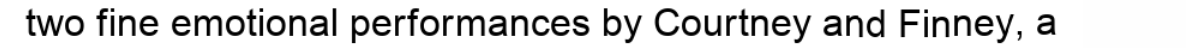

In [2208]:
show(cand_input_img[0][2])

In [ ]:
font_name = 'Arial'
case = 'paragraph'
title = f"{font_name}-{case}"
with open(f'attack_result/{title}.pkl', 'wb') as f:
    pickle.dump((adv_img, record_adv_text, record_iter, (duration, i)), f)

## paste wm

In [2030]:
pic = Image.open('pictures/wenli1.jpg')
def picture(height, width, pic):
    if pic.size[0] < width:
        pic = pic.resize([width, int(pic.size[1] * (width / pic.size[0]))], Image.ANTIALIAS)
    if pic.size[1] < height:
        pic = pic.resize([int(pic.size[0] * (height / pic.size[1])), height], Image.ANTIALIAS)
    x = 0 if pic.size[0] == width else rnd.randint(0, pic.size[0] - width)
    y = 0 if pic.size[1] == height else rnd.randint(0, pic.size[1] - height)
    return pic.crop((x, y, x + width, y + height))
width, height = img.size
bg_pic = picture(height, width, pic)

TypeError: 'int' object is not iterable

In [3004]:
# 得到水印 mask
wm_img = gen_wm((0, 0, 0))
wm_arr = np.array(wm_img.convert('L'))
kernel = np.ones((5, 5), np.uint8)
wm_arr = cv2.dilate(wm_arr, kernel, 2)
wm_arr = cv2.erode(wm_arr, kernel, 2)
bg_mask = ~(wm_arr != 255)
wm_img = np.array(Image.new(mode="RGB", size=wm_img.size, color=(0, 0, 0)))
wm_img[bg_mask] = 255
wm_img = Image.fromarray(wm_img)

In [1497]:
pos, frames = find_wm_pos(adv_img, cand_input_img, True)
# 按面积大小把pos从大到小排个序
new_pos = []
for _pos in pos:
    if len(_pos) > 1:
        new_pos.append(sorted(_pos, key=lambda x: (x[3]-x[1])*(x[2]-x[0]), reverse=True))
    else:
        new_pos.append(_pos)
pos = new_pos

In [1533]:
idx_dict = defaultdict(list)
for i, j in cand_img_idx:
    idx_dict[i].append(j)
    
new_cand_img_idx = []
for i in idx_dict.keys():
    new_cand_img_idx.append([idx[1] for idx in idx_dict[i]])
    
cand_img_idx = new_cand_img_idx
import copy
cand_idx_map = copy.deepcopy(cand_img_idx)
cnt = 0
for i, img_idx in enumerate(cand_img_idx):
    for j, idx in enumerate(img_idx):
        cand_idx_map[i][j] = cnt
        cnt += 1

In [2274]:
def get_wm_mask(pos_x, line_idx, bg_pic):
    wm_bg_img = Image.new(mode="RGB", size=bg_pic.size, color=(255, 255, 255))
#     xp = pos_x[0][0] - 10 if len(pos_x) != 0 else -10
    xp = int(pos_x)
    yp = int(-wm_img.size[1] // 3 + line_idx * 48)
    wm_gap = 400
    wm_bg_img.paste(wm_img, box=(xp - 2 * wm_gap, yp))
    wm_bg_img.paste(wm_img, box=(xp - wm_gap, yp))
    wm_bg_img.paste(wm_img, box=(xp, yp))
    wm_bg_img.paste(wm_img, box=(xp + wm_gap, yp))
    wm_bg_img.paste(wm_img, box=(xp + 2 * wm_gap, yp))
    wm_mask = (np.array(wm_bg_img.convert('L')) != 255)
    return wm_mask

In [3123]:
# img = img_list[75]
img = img
text_mask = get_text_mask(np.array(img))  # 得到 text 的 mask(bool)

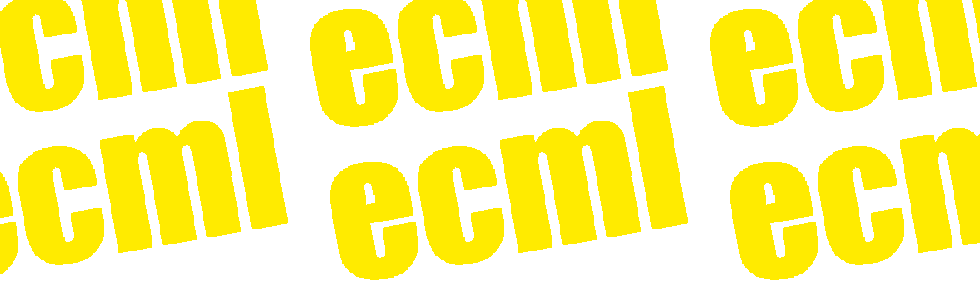

In [3155]:
bg_pic = Image.new(mode="RGB", size=img.size, color=(255, 235, 0))
rgb_img = Image.new(mode="RGB", size=img.size, color=(255, 255, 255))
wm_mask = get_wm_mask(pos_x=300, line_idx=0, bg_pic=bg_pic)
rgb_img.paste(bg_pic, mask=cvt2Image(wm_mask))
wm_mask = get_wm_mask(pos_x=320, line_idx=3.2, bg_pic=bg_pic)
rgb_img.paste(bg_pic, mask=cvt2Image(wm_mask))
# wm_mask = get_wm_mask(pos_x=300, line_idx=5, bg_pic=bg_pic)
# rgb_img.paste(bg_pic, mask=cvt2Image(wm_mask))
rgb_img

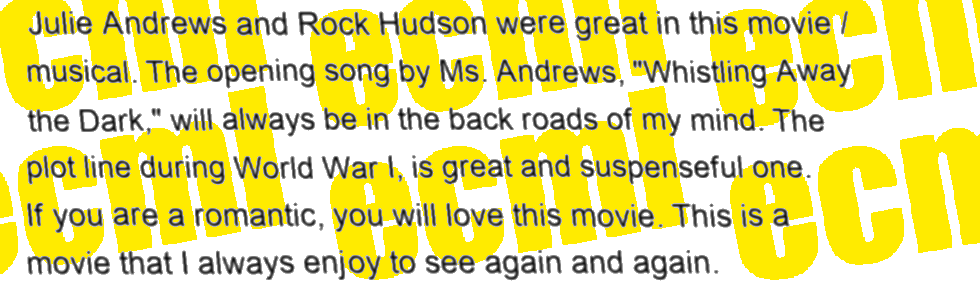

In [3156]:
rgb_img.paste(img, mask=cvt2Image(text_mask))  # 再贴 text
rgb_img

In [3148]:
a = (cvt2raw(np.array(rgb_img.convert('L')) / 255))
wm0_img_list = []
for i in range(0, 240, 48):
    wm0_img_list.append(a[:, i:i+48])
wm0_img = np.asarray(wm0_img_list)

In [2315]:
a = (cvt2raw(np.array(rgb_img.convert('L')) / 255))
wm_mask_list = []
for i in range(0, 240, 48):
    wm_mask_list.append(a[:, i:i+48])
wm_mask = np.asarray(wm_mask_list)

In [1887]:
pasted_img = []
wm_mask_list = []
for i, line_idx in enumerate(cand_img_idx):
    width, height = img_list[i].size
    bg_pic = picture(height, width, pic)
    rgb_img = Image.new(mode="RGB", size=bg_pic.size, color=(255, 255, 255))
    for j, idx in enumerate(line_idx):  # a full image
        pos_x = pos[cand_idx_map[i][j]]
        wm_mask = get_wm_mask(pos_x, idx, bg_pic)
        rgb_img.paste(bg_pic, mask=cvt2Image(wm_mask))
        wm_mask_list.append(transpose(wm_mask[idx * 48:(idx + 1) * 48]))
    pasted_img.append(rgb_img)
wm_mask = np.asarray(wm_mask_list)

In [1896]:
for text_img, p_img in zip(img_list, pasted_img):
    text_mask = get_text_mask(np.array(text_img))  # 得到 text 的 mask(bool)
    p_img.paste(text_img, mask=cvt2Image(text_mask))  # 再贴 text

In [1681]:
text_mask = np.asarray([get_text_mask(invert(text_img)) for text_img in cand_input_img])

In [1881]:
wm0_img_list = []
for i, line_idx in enumerate(cand_img_idx):
    img = pasted_img[i]
    img = np.array(img.convert('L'))
    for j, idx in enumerate(line_idx):
        wm0_img_list.append(cvt2raw(img[idx * 48:(idx + 1) * 48]) / 255)
wm0_img = np.asarray(wm0_img_list)

In [1683]:
with open('attack_result/Georgia-paragraph.pkl', 'wb') as f:
    pickle.dump((wm0_img, wm_mask, text_mask, pasted_img, cand_len_x, cand_target_txt, cand_gt_txt, cand_input_img, cand_img_idx, cand_idx_map), f)

## wm attack

In [2321]:
# build graph
with graph.as_default():
    # _ 是data_iterator如果是dataset input的话
    inputs, input_seq_len, targets, dropout_rate, _, _ = network.create_placeholders()
    output_seq_len, time_major_logits, time_major_softmax, logits, softmax, decoded, sparse_decoded, scale_factor, log_prob = \
        network.create_network(inputs, input_seq_len, dropout_rate, reuse_variables=tf.AUTO_REUSE)
    loss = tf.nn.ctc_loss(labels=targets,
                          inputs=time_major_logits,
                          sequence_length=output_seq_len,
                          time_major=True,
                          ctc_merge_repeated=True,
                          ignore_longer_outputs_than_inputs=True)
    loss = -tf.reduce_mean(loss, name='loss')
    grad, = tf.gradients(loss, inputs)

    # Normalize current gradient and add it to the accumulated gradient
    red_ind = list(range(1, len(grad.get_shape())))
    avoid_zero_div = tf.cast(1e-12, grad.dtype)
    divisor = tf.reduce_mean(tf.abs(grad), red_ind, keepdims=True)
    norm_grad = grad / tf.maximum(avoid_zero_div, divisor)

    m = tf.placeholder(tf.float32,
                       shape=inputs.get_shape().as_list(),
                       name="momentum")
    acc_m = m + norm_grad

    # watermark mask
    mask = tf.placeholder(tf.float32,
                          shape=inputs.get_shape().as_list(),
                          name="mask")
    grad = tf.multiply(acc_m, mask, name="mask_op")
    # eps_iter = 0.01
    # ord=np.inf
    optimal_perturbation = tf.sign(grad)
    optimal_perturbation = tf.stop_gradient(optimal_perturbation)
    scaled_perturbation_inf = utils_tf.mul(0.01, optimal_perturbation)
    # ord=1
    abs_grad = tf.abs(grad)
    max_abs_grad = tf.reduce_max(abs_grad, axis=red_ind, keepdims=True)
    tied_for_max = tf.to_float(tf.equal(abs_grad, max_abs_grad))
    num_ties = tf.reduce_sum(tied_for_max, axis=red_ind, keepdims=True)
    optimal_perturbation = tf.sign(grad) * tied_for_max / num_ties
    scaled_perturbation_1 = utils_tf.mul(0.01, optimal_perturbation)
    # ord=2
    square = tf.maximum(
        1e-12, tf.reduce_sum(tf.square(grad), axis=red_ind, keepdims=True))
    optimal_perturbation = grad / tf.sqrt(square)
    scaled_perturbation_2 = utils_tf.mul(0.01, optimal_perturbation)

Using CUDNN LSTM backend on GPU


In [2342]:
# input_img, len_x, target_txt, wm_mask
target_index_list = [np.asarray([c for c in encode(t)]) for t in target_txt]
input_img = wm0_img
with graph.as_default():
    adv_img = input_img.copy()
    m0 = np.zeros(input_img.shape)
    record_iter = np.zeros(input_img.shape[0])  # 0代表没成功
    start = time.time()
    for i in tqdm(range(nb_iter)):
        batch_iter = len(input_img) // batch_size
        batch_iter = batch_iter if len(input_img) % batch_size == 0 else batch_iter + 1
        for batch_i in range(batch_iter):
            batch_input_img = input_img[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_adv_img = adv_img[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_len_x = len_x[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_m0 = m0[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_target_txt = target_txt[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_tmp_y = [np.asarray([c - 1 for c in encode(t)]) for t in batch_target_txt]
            batch_y = sparse_tuple_from(batch_tmp_y)
            batch_mask = wm_mask[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_record_iter = record_iter[batch_size * batch_i:batch_size * (batch_i + 1)]

            scaled_perturbation = scaled_perturbation_2 if pert_type == '2' else scaled_perturbation_inf
            batch_pert = sess.run(scaled_perturbation,
                                  feed_dict={
                                      inputs: batch_adv_img,
                                      input_seq_len: batch_len_x,
                                      m: batch_m0,
                                      targets: batch_y,
                                      mask: batch_mask,
                                      dropout_rate: 0,
                                  })
            batch_pert[batch_record_iter != 0] = 0
            batch_adv_img = batch_adv_img + eps_iter * batch_pert
            batch_adv_img = batch_input_img + np.clip(batch_adv_img - batch_input_img, -eps, eps)
            batch_adv_img = np.clip(batch_adv_img, clip_min, clip_max)
            adv_img[batch_size * batch_i:batch_size * (batch_i + 1)] = batch_adv_img

        record_adv_text = []
        for batch_i in range(batch_iter):
            batch_adv_img = adv_img[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_len_x = len_x[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_target_index = target_index_list[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_adv_text = sess.run(decoded,
                                      feed_dict={
                                          inputs: batch_adv_img,
                                          input_seq_len: batch_len_x,
                                          dropout_rate: 0,
                                      })
            batch_adv_index = TensorflowModel._TensorflowModel__sparse_to_lists(batch_adv_text)
            record_adv_text += [''.join(decode(index)) for index in batch_adv_index]
            for j in (range(len(batch_target_index))):
                # attack img j successfully at iter i
                adv_index, target_index = batch_adv_index[j], batch_target_index[j]
                idx_j = batch_size * batch_i + j
                if np.sum(adv_index != target_index) == 0 and record_iter[idx_j] == 0:
                    record_iter[idx_j] = i
        if np.sum(record_iter == 0) == 0:  # all examples are successful
            break













































  0%|          | 0/1000 [00:00<?, ?it/s]/home/chenlu/anaconda2/envs/ocr1/lib/python3.6/site-packages/ipykernel/__main__.py:56: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.












































  0%|          | 1/1000 [00:00<03:46,  4.41it/s]











































  0%|          | 3/1000 [00:00<03:02,  5.46it/s]











































  0%|          | 5/1000 [00:00<02:33,  6.47it/s]











































  1%|          | 7/1000 [00:00<02:13,  7.47it/s]











































  1%|          | 9/1000 [00:00<01:58,  8.38it/s]











































  1%|          | 11/1000 [00:01<01:48,  9.13it/s]











































  1%|▏         | 13/1000 [00:01<01:41,  9.75it/s]











































  2%|▏         | 15/1000 [00:01<01:35, 10.29it/s

In [2351]:
adv_img = backup_adv_img.copy()

In [2352]:
adv_img = np.swapaxes(adv_img, 1, 2)
adv_img = cvt2Image(1 - adv_img.reshape((48 * 5, width)))

In [2345]:
record_adv_text

['This is one of the scariest movies I have ever seen. This,',
 "in my opinion, is Rob Lowe at his worst. I'm not quite sure",
 'why this film has gotten such a high rating. I guess you',
 'either love it or hate it, but if nothing else, it is not',
 'definitely worth a rental.']

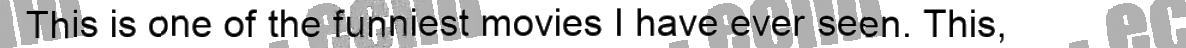

In [2344]:
show(adv_img[0])

## put adv line back

In [1897]:
output_img = []
for i, line_idx in enumerate(cand_img_idx):
    img_i = 1 - np.array(pasted_img[i].convert('L')).T / 255
    for j, idx in enumerate(line_idx):  # a full image
        img_i[:, idx * 48:(idx+1)*48] = adv_img[cand_idx_map[i][j]]
    output_img.append(img_i)

In [1916]:
with open('wm_result/Georgia-paragraph.pkl', 'wb') as f:
    pickle.dump((adv_img, output_img, record_adv_text, record_iter), f)

In [2522]:
grayscale = 0 # 灰度值在 76-226 有对应的彩色水印值，为了增加扰动后还在范围内，128-174
color = (grayscale, grayscale, grayscale)
wm_img = np.array(Image.new(mode="RGB", size=wm_img.size, color=color))
wm_img[bg_mask] = 255
wm_img = Image.fromarray(wm_img)

In [2521]:
wm_img.save('wm_img.jpg')

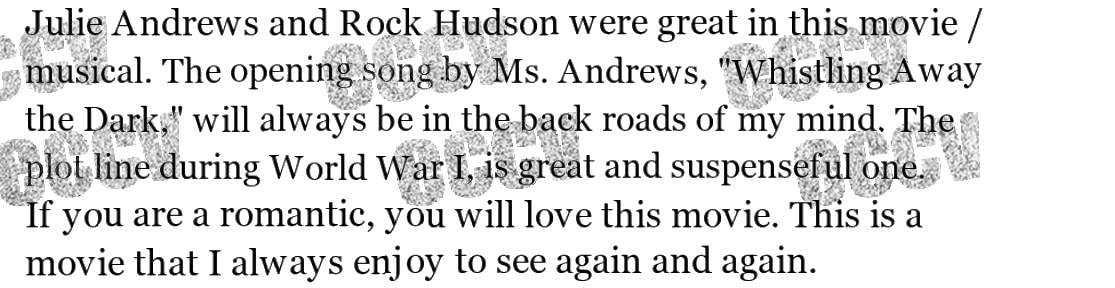

In [1937]:
pasted_img[1].convert('L')

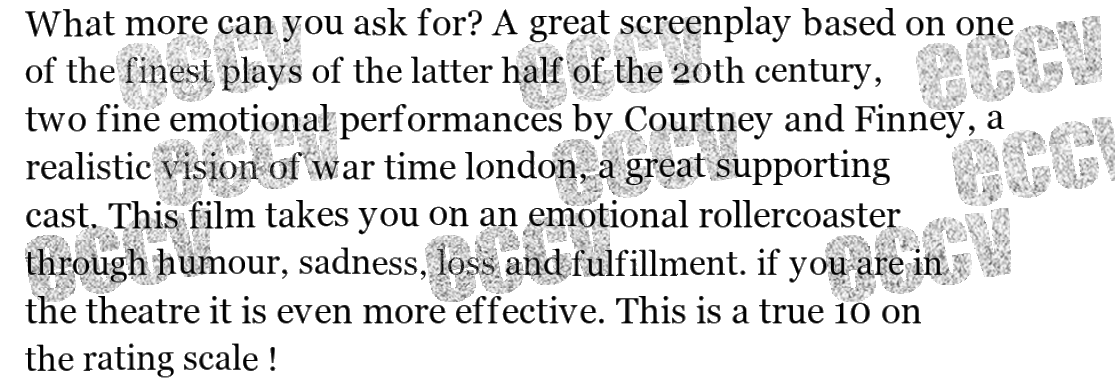

In [1899]:
show(output_img[0])

In [1904]:
text_mask = [get_text_mask(np.array(img.convert('L')) / 255) for img in img_list]

In [2366]:
gray_img = np.array(adv_img) / 255
op_mask = (~(gray_img == 1)) & (~text_mask) # not_bg & not_text

In [2369]:
rgb_img = np.ones(list(gray_img.shape) + [3])
rgb_img[:, :, 0] = gray_img
rgb_img[:, :, 1] = gray_img
rgb_img[:, :, 2] = gray_img
r = 1
b = 0
rgb_img[op_mask, 0] = r
rgb_img[op_mask, 1] = (gray_img[op_mask] - 0.299 * r - 0.114 * b) / 0.587
rgb_img[op_mask, 2] = b

In [2371]:
color_sample = Image.fromarray((rgb_img * 255).astype('uint8'))

In [2372]:
color_sample.save('result_pic/color_sample.jpg', quality=100)

In [2536]:
color_sample = Image.open('result_pic/color_sample.jpg')

In [2566]:
from skimage.measure import compare_mse, compare_psnr, compare_ssim

In [2568]:
imga.shape, imgb.shape

((240, 955), (240, 1186))

In [2598]:
imga = np.array(rgb_img.convert('L'))
imgb = np.array(color_sample.convert('L'))
print(compare_mse(imga, imgb))
print(compare_psnr(imga, imgb))
print(compare_ssim(imga, imgb))

9.358097948285554
38.41892774363394
0.9912957651693644


In [2596]:
imga = np.array(rgb_img.convert('L'))
imgb = np.array(color_sample.convert('L'))

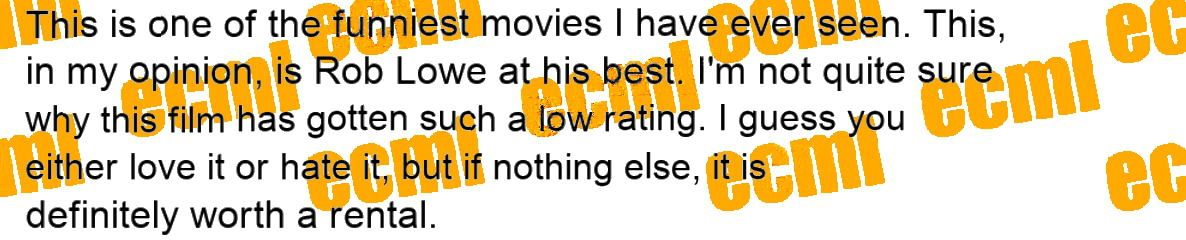

In [2597]:
color_sample

In [ ]:
rgb_img = cvt2rgb(output_img[0], text_mask[0])

# show examples

In [2809]:
case = 'hard'
font_name = 'Arial'
pert_type, eps_iter = '2', 5.0
title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
print(title)
with open(f'attack_result/{title}.pkl', 'rb') as f:
    adv_img, record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)

Arial-hard-l2-eps0.2-ieps5.0-iter1000


In [2811]:
with open(f'{img_data_path}/Arial-hard.pkl', 'rb') as f:
    img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)

In [ ]:
rgb_img = Image.new(mode="RGB", size=text_img.size, color=(255, 255, 255))
p = -int(wm_img.size[0] * np.tan(10 * np.pi / 180))
rgb_img.paste(wm_img, box=(pert_pos[0], p))
text_mask = get_text_mask(np.array(text_img))
rgb_img.paste(text_img, mask=cvt2Image(text_mask))
rgb_img

# real world images

In [2830]:
real = Image.open('opt-real-images/scan/scan6.jpg').convert('L')
real_img = np.array(real)

In [2719]:
cvt2Image(a).save(f'opt-real-images/{txt[0]}.jpg', quality=100)

In [2778]:
real_img.shape

(3230, 801)

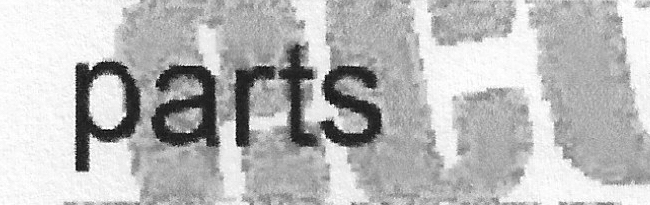

In [2831]:
# a = real_img[190:386, :500]
# a = real_img[400:580, :500]
# a = real_img[600:790, :650] # seales
# a = real_img[800:1005, :650] # seats
# a = real_img[1010:1200, :650] # states
# a = real_img[1210:1410, :650] # saltes
# a = real_img[1410:1615, :650]
# a = real_img[1615:1815, :650] # encom
s, e = 1410, 1615
a = real_img[s:e, :650] # rapcon
cvt2Image(a) 

In [2800]:
os.mkdir('opt-real-images/taped')

In [2808]:
pytesseract.image_to_string(cvt2Image(a))

'parts -'

In [2807]:
for i in range(-10, 11):
    for j in range(-10, 11):
        a = real_img[s+i:e+j, :650] # rapcon
        txt = [r.sentence for r in predictor.predict_raw([a], progress_bar=False)]
        if txt[0] in tmp_dict and len(txt[0]) > 2:
            cvt2Image(a).save(f'opt-real-images/parts/{txt[0]}.jpg', quality=100)

In [2721]:
txt = [r.sentence for r in predictor.predict_raw([a], progress_bar=False)]
txt

['racxn']

In [2832]:
[r.sentence for r in predictor.predict_raw([np.array(Image.open('line.jpg').convert('L'))], progress_bar=False)]

['Ths is one of the toniest moves 1nave ever seen.']

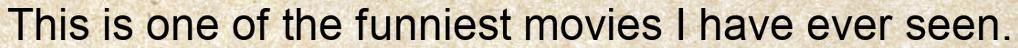

In [2834]:
Image.open('line.jpg')

In [2626]:
input_img, len_x = preprocess([cvt2Image(a)])

In [2629]:
with graph.as_default():
    adv_text = sess.run(decoded,
                        feed_dict={
                            inputs: input_img,
                            input_seq_len: len_x,
                            dropout_rate: 0,
                        })
    adv_index = TensorflowModel._TensorflowModel__sparse_to_lists(adv_text)
    adv_text = [''.join(decode(index)) for index in adv_index]

In [2630]:
adv_text

['e']

In [3023]:
img0 = Image.open('opt-real-images/protect.jpg')

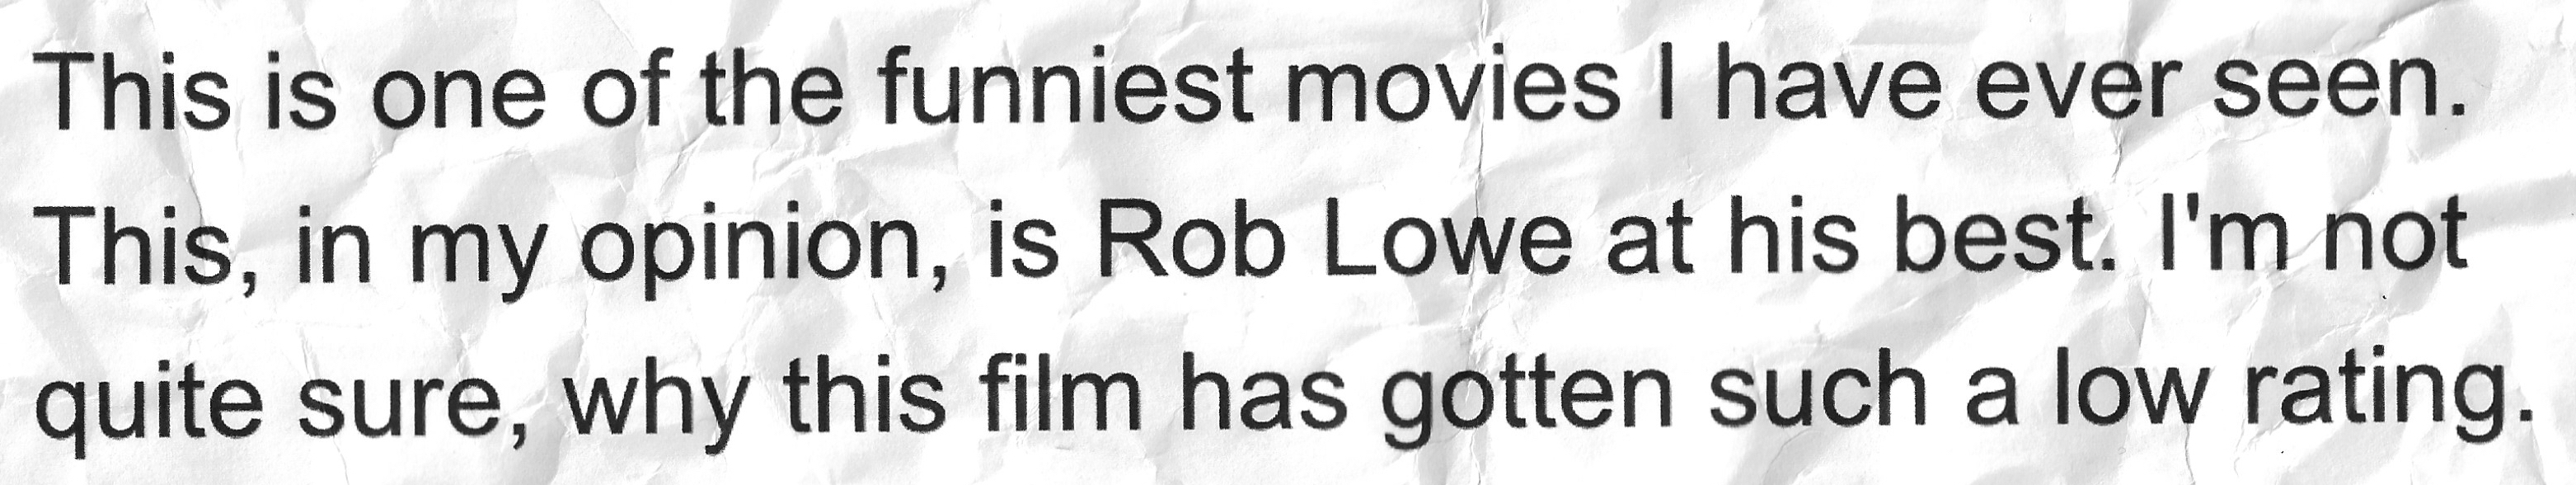

In [3024]:
img0

In [2990]:
img0_arr = np.array(img0.convert('L'))
imgs = [img0_arr[i:int(i+img0_arr.shape[0]/3), :] for i in range(0, img0_arr.shape[0], int(img0_arr.shape[0]/3))]

In [3025]:
img1 = img0.resize(size=(int(img0.size[0] / img0.size[1] * 48 * 3), 48 * 3))
img1_arr = np.array(img1.convert('L'))
imgs = [img1_arr[i:int(i+img1_arr.shape[0]/3), :] for i in range(0, img1_arr.shape[0], int(img1_arr.shape[0]/3))]
imgs = np.asarray(imgs)
imgs = np.swapaxes(1 - imgs / 255, 1, 2)

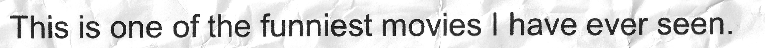

In [3026]:
show(imgs[0])

In [3027]:
len_x = [imgs.shape[1]] * 3

In [3028]:
with graph.as_default():
    adv_text = sess.run(decoded,
                        feed_dict={
                            inputs: imgs, # adv_img
                            input_seq_len: len_x,
                            dropout_rate: 0,
                        })
    adv_index = TensorflowModel._TensorflowModel__sparse_to_lists(adv_text)
    adv_text = [''.join(decode(index)) for index in adv_index]

In [3029]:
adv_text

[' This is one of the funniest movies 1 have ever seen.',
 ' This, in my opinion, is Rob Lowe at his best. m not',
 'quite sure, why this fim has gotten sch a loW ran9-']